# Summarize GWAS (meta-analysis) vs. eQTL analysis

In [252]:
library(kohonen)

In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [3]:
loci             = add_rownames(fread  ("pipeline/1.2.genomewide_significant_loci/loci.txt"          , sep = "\t", header = TRUE, data.table = FALSE))
manifest         = add_rownames(fread  ("pipeline/1.1.sumstats/manifest.txt"                         , sep = "\t", header = TRUE, data.table = FALSE))
moloc_df         =              fread  ("pipeline/2.2.moloc/moloc.txt"                               , sep = "\t", header = TRUE, data.table = FALSE)
locus2coloc      =              fread  ("pipeline/5.4.analyze_coloc_qtl_som_maps/signal2coloc.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
meta_list        = lapply(locus2coloc$id, function(id){readRDS(paste0("pipeline/5.5.meta_analysis/coloc_data/", id, ".rds"))})
names(meta_list) = locus2coloc$id

In [42]:
exp_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")
qtl_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )


In [26]:
eqtl_coloc = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [18]:
read_coloc = function(id)
{
    x     = meta_list[[id]]
    som   = x[["som"  ]]
    eqtls = x[["eqtls"]]
    coloc = x[["coloc"]]
    colnames(som)[[2]] = "signal_id"
    
    if(nrow(eqtls) > 0)
    {
        out   = suppressWarnings(cbind(som, eqtls[, c("transcript_id", "gene_id", "gene_name", "type", "phenotype")], as.data.frame(rbindlist(lapply(1:nrow(eqtls), function(ii)
        {
            transcript_id = eqtls[ii, "transcript_id"]
            type          = eqtls[ii, "type"         ]

            return(coloc[[transcript_id]][[paste("type", type)]][["pp"]])
        })), stringsAsFactors = FALSE)))
    }else
    {
        out = NULL
    }

    return(out)
}

coloc_eqtls = as.data.frame(rbindlist(lapply(names(meta_list), function(signal_id){read_coloc(signal_id)})),stringsAsFactors = FALSE)

fwrite(coloc_eqtls, "pipeline/5.5.meta_analysis/coloc_eqtls.txt", sep = "\t", col.names = TRUE, row.names = FALSE)



In [171]:
coordinates      = exp_data[["coordinates"]]
qtl2cell         = rbind(qtl_data[["interactions"]][["rna"]], qtl_data[["interactions"]][["isoform"]])
qtl2cell         = qtl2cell[ qtl2cell$cell == TRUE, c("transcript_id", "type", "gene_name", "interaction")]
qtl2cell$tr2type = paste(qtl2cell$transcript_id, qtl2cell$type, sep = ":")
qtl_cell         = aggregate(interaction ~ tr2type, data = qtl2cell, function(x){paste(sort(unique(x)), collapse = ", ")})

In [46]:
eqtls_gene    = qtl_data[["qtl"]][["rna"    ]]
eqtls_isoform = qtl_data[["qtl"]][["isoform"]]

eqtls_gene    = eqtls_gene   [ eqtls_gene   $egene == TRUE, ]
eqtls_isoform = eqtls_isoform[ eqtls_isoform$egene == TRUE, ]


In [253]:
moloc_map_list = readRDS("pipeline/2.2.moloc/moloc_map_list.rds")
map            = moloc_map_list[["som"]][["map"     ]]
g              = moloc_map_list[["som"]][["som_grid"]]
clusters       = moloc_map_list[["som"]][["clusters"]]

In [360]:
qtl2cell_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/cell_type_associations/qtl2cell.rds")

In [361]:
for(x in names(qtl2cell_list))
{
    qtl2cell_list[[x]][,"by_tissue:ipsc_cvpc"] = NULL
    
    colnames(qtl2cell_list[[x]]) = gsub("by_organ:adult", "by_stage:adult", gsub("by_organ:ipsc_cvpc", "by_stage:ipsc_cvpc", colnames(qtl2cell_list[[x]])))
}

# test associations between cell types and GWAS

In [173]:
signal2qtl         = coloc_eqtls[ coloc_eqtls$PP.H4.abf >= 0.8,]
signal2qtl$tr2type = paste(signal2qtl$transcript_id, signal2qtl$type, sep = ":")
cells              = sort(unique(qtl2cell$interaction))

In [179]:
signal2int = as.data.frame(rbindlist(lapply(locus2coloc$id, function(id)
{
    out                 = locus2coloc[ locus2coloc$id == id, ]
    out[1, cells]       = FALSE
    out[1, manifest$id] = FALSE
    
    this_signal2qtl = signal2qtl[ signal2qtl$signal_id == id,]
    
    if(nrow(this_signal2qtl) > 0)
    {
        this_cell     = qtl2cell[ qtl2cell$tr2type %in% this_signal2qtl$tr2type,]

        for(cell in cells)
        {
            if(nrow(this_cell[this_cell$interaction == cell,]) > 0){out[1, cell] = TRUE}
        }
    }
    
    traits = unlist(strsplit(out[1, "traits"], "; "))
    
    out[1, traits] = TRUE
    
    return(out)
})), stringsAsFactors = FALSE)

In [270]:
fwrite(signal2int, "pipeline/5.5.meta_analysis/gwas2cell_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [389]:
str(signal2int)

'data.frame':	3426 obs. of  20 variables:
 $ chrom       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pos         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ som         : int  376 376 376 348 376 376 376 33 376 357 ...
 $ id          : chr  "17_68319330_68611145.1" "18_55765613_56357531.1" "5_130403286_131933599.2" "13_25708286_26013798.1" ...
 $ locus       : chr  "17_68319330_68611145" "18_55765613_56357531" "5_130403286_131933599" "13_25708286_26013798" ...
 $ cluster     : int  7 7 7 17 7 7 7 28 7 7 ...
 $ class       : chr  "V376" "V376" "V376" "V348" ...
 $ traits      : chr  "biomarkers-30760-both_sexes-irnt; biomarkers-30870-both_sexes-irnt" "biomarkers-30760-both_sexes-irnt; biomarkers-30870-both_sexes-irnt" "biomarkers-30760-both_sexes-irnt; biomarkers-30870-both_sexes-irnt" "biomarkers-30870-both_sexes-irnt; continuous-MAP-both_sexes-combined_medadj_irnt; continuous-SBP-both_sexes-com"| __truncated__ ...
 $ traits_n    : int  2 2 2 3 2 2 2 2 2 3 ...
 $ eqtls       : chr  "" "" "" "" ...
 $ eqtl

# Test associations between loci, traits and eQTLs
## if a locus has multiple traits, do the eGenes at the same locus have multiple conditional eQTLs and/or are the genes at the same locus more likely to have eQTLs?
- test if the eGenes/eIsoforms associated with the 722 signal have different associations with stage/organ/tissue/cell types than expected from Figure 3B-I
- if a locus has multiple signals, are the eGenes at the same locus more likely to have conditional eQTLs?

- ``loci with more traits are enriched for eGenes because they are gene-rich``

In [277]:
dir.create("pipeline/5.5.meta_analysis/loci_vs_qtls", showWarnings = FALSE)

In [292]:
loci2bed       = loci[ loci$locus %in% signal2int$locus,]
loci2bed$chrom = paste0("chr", loci2bed$chrom)

In [300]:
loci_bed           = "pipeline/5.5.meta_analysis/loci_vs_qtls/loci.bed"
genes_bed          = "/frazer01/reference/private/Gencode.v34lift37/gene.bed"
loci2gene_int_file = "pipeline/5.5.meta_analysis/loci_vs_qtls/intersect_loci_gene.txt"

fwrite(loci2bed[order(loci2bed$chrom, loci2bed$from, loci2bed$to), c("chrom", "from", "to", "locus")], loci_bed, sep = "\t", col.names = FALSE, row.names = FALSE)

command = paste("bedtools", "intersect", "-loj", "-a", loci_bed, "-b", genes_bed, "| cut -f4,8", ">", loci2gene_int_file)

system(command)

locus2gene           = fread(loci2gene_int_file, sep = "\t", header = FALSE, data.table = FALSE)
colnames(locus2gene) = c("locus", "gene_id")
locus2gene           = locus2gene[ locus2gene$gene_id %in% qtl_data$qtl$rna$gene_id,]


In [301]:
length(unique(locus2gene$locus))
length(unique(locus2gene$gene_id))


[1] 1631

[1] 12045

In [322]:
calculate_overlap_locus_eqtl = function(locus, phenotypes)
{
    out = locus2qtl[locus,]
    
    for(phenotype in phenotypes)
    {
        qtl = qtl_data[["qtl"]][[phenotype]]
        qtl = qtl[qtl$gene_id %in% locus2gene[locus2gene$locus == locus, "gene_id"],]
        
        for(type in 0:5)
        {
            out[1, paste(phenotype, "expressed", type, sep = "_")] = length(unique(qtl[qtl$type == type                    , "transcript_id"]))
            out[1, paste(phenotype, "eqtl"     , type, sep = "_")] = length(unique(qtl[qtl$type == type & qtl$egene == TRUE, "transcript_id"]))
            out[1, paste(phenotype, "eqtl_x"   , type, sep = "_")] = length(unique(qtl[qtl$type == type & qtl$egene == TRUE, "transcript_id"])) / length(unique(qtl[qtl$type == type, "transcript_id"]))
        }
    }
    return(out)
}

locus2qtl           = moloc_df[ moloc_df$locus %in% signal2int$locus, c("locus", "chrom", "from", "to", "size", "n_signif", "n_signals")]
rownames(locus2qtl) = locus2qtl$locus
locus2qtl           = as.data.frame(rbindlist(lapply(locus2qtl$locus, function(locus){calculate_overlap_locus_eqtl(locus, c("rna", "isoform"))})), stringsAsFactors = FALSE)

fwrite(locus2qtl, "pipeline/5.5.meta_analysis/loci_vs_qtls/locus2qtl.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


### GWAS loci are slightly less likely to overlap eGenes and eIsoforms than the rest of the genome

In [355]:
calculate_qtl_enrichment_phenotype = function(type, phenotype)
{
    qtl = qtl_data[["qtl"]][[phenotype]]
    qtl = qtl[qtl$type == type,]
    
    out = data.frame(phenotype      = phenotype, 
                     type           = type     ,
                     expressed      = nrow(qtl),
                     egenes         = nrow(qtl[                                       qtl$egene == TRUE,]),
                     in_loci        = nrow(qtl[ qtl$gene_id %in% locus2gene$gene_id                    ,]),
                     in_loci_egenes = nrow(qtl[ qtl$gene_id %in% locus2gene$gene_id & qtl$egene == TRUE,])
                    )
    
    totest = matrix(c(out[1, "in_loci_egenes"], 
                      out[1, "in_loci"       ] - out[1, "in_loci_egenes"],
                      out[1, "egenes"        ] - out[1, "in_loci_egenes"],
                      out[1, "expressed"     ] - out[1, "egenes"        ] - out[1, "in_loci"] + out[1, "in_loci_egenes"]),
                    nrow = 2, byrow = TRUE
                   )
    
    
    test = fisher.test(totest)
    
    out$estimate = test$estimate
    out$ci1      = test$conf.int[[1]]
    out$ci2      = test$conf.int[[2]]
    out$pval     = test$p.value
    
    return(out)
}

type = 0
phenotype = "rna"

test_vs_genome = as.data.frame(rbindlist(lapply(c("rna", "isoform"), function(phenotype)
{
    as.data.frame(rbindlist(lapply(0:5, function(type)
    {
        calculate_qtl_enrichment_phenotype(type, phenotype)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)


In [356]:
test_vs_genome

phenotype type expressed egenes in_loci in_loci_egenes estimate  ci1       
1  rna       0    19586     11692  12045   7111           0.9312665 0.87766944
2  rna       1    11692      4394   7111   2652           0.9692742 0.89718215
3  rna       2     4394      1315   2652    796           1.0106330 0.88379912
4  rna       3     1315       395    796    253           1.2368101 0.96278534
5  rna       4      395       160    253    100           0.8935043 0.57633927
6  rna       5      160        74    100     51           1.6689146 0.83174769
7  isoform   0    37032      7165  24254   4618           0.9446936 0.89479403
8  isoform   1     7165       988   4618    606           0.8560896 0.74396338
9  isoform   2      988       234    606    140           0.9205425 0.67520053
10 isoform   3      234        72    140     44           1.0799718 0.59068298
11 isoform   4       72        23     44     12           0.5840676 0.18863221
12 isoform   5       23         7     12      2           0.2561821 0.01868282
   ci2       pval      
1  0.9880405 0.01802686
2  1.0472754 0.43402882
3  1.1561302 0.89286970
4  1.5922629 0.09657309
5  1.3877830 0.59548035
6  3.3952870 0.14158146
7  0.9975029 0.03925270
8  0.9858979 0.02899780
9  1.2583255 0.59151868
10 1.9934507 0.88527283
11 1.8000977 0.31092092
12 2.1953634 0.19302733

### Loci with multiple traits are loci that have many expressed genes

In [337]:
summary(lm(rna_expressed_0 ~ n_signif  + size, data = locus2qtl))
summary(lm(rna_expressed_0 ~ n_signals + size, data = locus2qtl))



Call:
lm(formula = rna_expressed_0 ~ n_signif + size, data = locus2qtl)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.776  -2.764   0.022   2.099  83.968 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.896e+00  2.869e-01 -13.580  < 2e-16 ***
n_signif     3.506e-01  8.975e-02   3.906  9.7e-05 ***
size         1.655e-05  4.649e-07  35.610  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.534 on 1922 degrees of freedom
Multiple R-squared:  0.6095,	Adjusted R-squared:  0.6091 
F-statistic:  1500 on 2 and 1922 DF,  p-value: < 2.2e-16



Call:
lm(formula = rna_expressed_0 ~ n_signals + size, data = locus2qtl)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.294  -2.678   0.115   2.060  83.207 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.727e+00  3.378e-01 -13.991  < 2e-16 ***
n_signals    1.295e+00  2.171e-01   5.966 2.89e-09 ***
size         1.595e-05  4.547e-07  35.072  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.489 on 1922 degrees of freedom
Multiple R-squared:  0.6135,	Adjusted R-squared:  0.6131 
F-statistic:  1526 on 2 and 1922 DF,  p-value: < 2.2e-16


In [340]:
summary(aov(rna_expressed_0 ~ n_signif  + size, data = locus2qtl))
summary(aov(rna_expressed_0 ~ n_signals + size, data = locus2qtl))


              Df Sum Sq Mean Sq F value Pr(>F)    
n_signif       1 126100  126100    1732 <2e-16 ***
size           1  92348   92348    1268 <2e-16 ***
Residuals   1922 139968      73                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq F value Pr(>F)    
n_signals      1 131254  131254    1821 <2e-16 ***
size           1  88647   88647    1230 <2e-16 ***
Residuals   1922 138514      72                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [343]:
summary(aov(isoform_expressed_0 ~ n_signif  + size, data = locus2qtl))
summary(aov(isoform_expressed_0 ~ n_signals + size, data = locus2qtl))


              Df Sum Sq Mean Sq F value Pr(>F)    
n_signif       1 514509  514509    1524 <2e-16 ***
size           1 368792  368792    1092 <2e-16 ***
Residuals   1922 648882     338                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq F value Pr(>F)    
n_signals      1 536599  536599    1605 <2e-16 ***
size           1 353144  353144    1057 <2e-16 ***
Residuals   1922 642440     334                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### the fraction of genes that have eQTLs is not associated with the number of significant traits

In [383]:
summary(lm(rna_eqtl_x_0 ~ n_signif  + size + rna_expressed_0, data = locus2qtl))
summary(lm(rna_eqtl_x_0 ~ n_signals + size + rna_expressed_0, data = locus2qtl))



Call:
lm(formula = rna_eqtl_x_0 ~ n_signif + size + rna_expressed_0, 
    data = locus2qtl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64960 -0.16388  0.01142  0.25142  0.42733 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.883e-01  1.223e-02  48.094   <2e-16 ***
n_signif         5.549e-03  3.455e-03   1.606    0.108    
size            -1.885e-08  2.260e-08  -0.834    0.404    
rna_expressed_0 -2.280e-04  8.560e-04  -0.266    0.790    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3174 on 1627 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.001633,	Adjusted R-squared:  -0.0002078 
F-statistic: 0.8871 on 3 and 1627 DF,  p-value: 0.4471



Call:
lm(formula = rna_eqtl_x_0 ~ n_signals + size + rna_expressed_0, 
    data = locus2qtl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61977 -0.16177  0.01378  0.24933  0.42001 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.848e-01  1.438e-02  40.666   <2e-16 ***
n_signals        1.084e-02  8.371e-03   1.295    0.196    
size            -1.380e-08  2.204e-08  -0.626    0.531    
rna_expressed_0 -2.627e-04  8.602e-04  -0.305    0.760    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3175 on 1627 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.001079,	Adjusted R-squared:  -0.0007629 
F-statistic: 0.5858 on 3 and 1627 DF,  p-value: 0.6243


In [341]:
summary(aov(rna_eqtl_x_0 ~ n_signif  + size + rna_expressed_0, data = locus2qtl))
summary(aov(rna_eqtl_x_0 ~ n_signals + size + rna_expressed_0, data = locus2qtl))


                  Df Sum Sq Mean Sq F value Pr(>F)
n_signif           1   0.09 0.09223   0.915  0.339
size               1   0.17 0.16878   1.675  0.196
rna_expressed_0    1   0.01 0.00715   0.071  0.790
Residuals       1627 163.94 0.10076               
294 observations deleted due to missingness

                  Df Sum Sq Mean Sq F value Pr(>F)
n_signals          1   0.06 0.05658   0.561  0.454
size               1   0.11 0.11119   1.103  0.294
rna_expressed_0    1   0.01 0.00940   0.093  0.760
Residuals       1627 164.03 0.10082               
294 observations deleted due to missingness

In [344]:
summary(aov(isoform_eqtl_x_0 ~ n_signif  + size + isoform_expressed_0, data = locus2qtl))
summary(aov(isoform_eqtl_x_0 ~ n_signals + size + isoform_expressed_0, data = locus2qtl))


                      Df Sum Sq Mean Sq F value Pr(>F)  
n_signif               1    0.0 0.00452   0.115 0.7351  
size                   1    0.0 0.00039   0.010 0.9205  
isoform_expressed_0    1    0.2 0.20176   5.111 0.0239 *
Residuals           1421   56.1 0.03948                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
500 observations deleted due to missingness

                      Df Sum Sq Mean Sq F value Pr(>F)  
n_signals              1   0.00 0.00014   0.003 0.9529  
size                   1   0.01 0.00947   0.240 0.6244  
isoform_expressed_0    1   0.20 0.19525   4.946 0.0263 *
Residuals           1421  56.10 0.03948                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
500 observations deleted due to missingness

### same for conditional eQTLs

In [358]:
summary(aov(rna_eqtl_x_1 ~ n_signif  + size + rna_expressed_1, data = locus2qtl))
summary(aov(rna_eqtl_x_1 ~ n_signals + size + rna_expressed_1, data = locus2qtl))


                  Df Sum Sq Mean Sq F value Pr(>F)  
n_signif           1   0.00  0.0009   0.008 0.9285  
size               1   0.07  0.0662   0.564 0.4527  
rna_expressed_1    1   0.39  0.3856   3.284 0.0702 .
Residuals       1419 166.63  0.1174                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
502 observations deleted due to missingness

                  Df Sum Sq Mean Sq F value Pr(>F)  
n_signals          1   0.00  0.0004   0.003 0.9541  
size               1   0.07  0.0689   0.587 0.4438  
rna_expressed_1    1   0.38  0.3761   3.203 0.0737 .
Residuals       1419 166.64  0.1174                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
502 observations deleted due to missingness

### are 

In [363]:
qtl2cell = qtl2cell_list[["all"]]

In [387]:
test_overlap_loci_cell = function(loci2test, phenotype, cell_types)
{
    qtl      = qtl_data[["qtl"]][[phenotype]]
    cell     = qtl_data[["interactions"]][[phenotype]]
    in_loci  = locus2gene[ locus2gene$locus %in% loci2test & locus2gene$gene_id %in% qtl$gene_id, "gene_id"]
    in_loci  = unique(qtl [ qtl $gene_id     %in% in_loci                       , "transcript_id"])
    has_eqtl = unique(qtl [ qtl $egene       ==   TRUE                          , "transcript_id"])
    has_cell = unique(cell[ cell$interaction %in% cell_types & cell$cell == TRUE, "transcript_id"])
    all      = unique(qtl$transcript_id)
    
    
    x11      = length(                                       intersect(in_loci , has_cell) )
    x12      = length(setdiff(intersect(in_loci , has_eqtl), intersect(in_loci , has_cell)))
    x21      = length(setdiff(has_cell                     , intersect(in_loci , has_cell)))
    x22      = length(setdiff(has_eqtl                     , c(        in_loci , has_cell)))
    
    mytable  = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test     = fisher.test(mytable)
    
    message(paste(phenotype, paste(cell_types, collapse = ", "), paste("p", signif(test$p.value, digits = 3), sep = " = "), paste("estimate", signif(test$estimate, digits = 3), sep = " = "), sep = "; "))
}

loci2test  = unique(signal2int[ signal2int$eqtls_n > 0, "locus"])
phenotype  = "rna"
cell_types = c("ipsc_cvpc", "adult")

test_overlap_loci_cell(loci2test, "rna", c("ipsc_cvpc", "adult"  ))
test_overlap_loci_cell(loci2test, "rna", c("heart"    , "arteria"))
test_overlap_loci_cell(loci2test, "rna", c("heart_atrium"   , "heart_ventricle", "arteria_aorta", "arteria_coronary"))
test_overlap_loci_cell(loci2test, "rna", colnames(signal2int)[grepl("cibersort", colnames(signal2int)) == TRUE])

test_overlap_loci_cell(loci2test, "isoform", c("ipsc_cvpc", "adult"  ))
test_overlap_loci_cell(loci2test, "isoform", c("heart"    , "arteria"))
test_overlap_loci_cell(loci2test, "isoform", c("heart_atrium"   , "heart_ventricle", "arteria_aorta", "arteria_coronary"))
test_overlap_loci_cell(loci2test, "isoform", colnames(signal2int)[grepl("cibersort", colnames(signal2int)) == TRUE])



rna; ipsc_cvpc, adult; p = 0.815; estimate = 1.02

rna; heart, arteria; p = 0.00121; estimate = 1.24

rna; heart_atrium, heart_ventricle, arteria_aorta, arteria_coronary; p = 0.0507; estimate = 1.15

rna; cibersort.regular.cardiac_muscle, cibersort.regular.cardiac_neuron, cibersort.regular.endocardial, cibersort.regular.endothelial, cibersort.regular.fibroblast, cibersort.regular.immune, cibersort.regular.myofibroblast, cibersort.regular.smooth_muscle; p = 0.000357; estimate = 1.25

isoform; ipsc_cvpc, adult; p = 0.044; estimate = 0.773

isoform; heart, arteria; p = 0.646; estimate = 1.06

isoform; heart_atrium, heart_ventricle, arteria_aorta, arteria_coronary; p = 0.712; estimate = 0.935

isoform; cibersort.regular.cardiac_muscle, cibersort.regular.cardiac_neuron, cibersort.regular.endocardial, cibersort.regular.endothelial, cibersort.regular.fibroblast, cibersort.regular.immune, cibersort.regular.myofibroblast, cibersort.regular.smooth_muscle; p = 0.745; estimate = 0.963



In [388]:
test_overlap_loci_cell = function(loci2test, phenotype, cell_types)
{
    qtl      = qtl_data[["qtl"]][[phenotype]]
    cell     = qtl_data[["interactions"]][[phenotype]]
    in_loci  = locus2gene[ locus2gene$locus %in% loci2test   & locus2gene$gene_id %in% qtl$gene_id, "gene_id"]
    in_loci  = unique(qtl [ qtl $gene_id     %in% in_loci                       , "transcript_id"])
    has_eqtl = unique(qtl [ qtl $egene       ==   TRUE       & qtl $gene_id %in% locus2gene$gene_id, "transcript_id"])
    has_cell = unique(cell[ cell$interaction %in% cell_types & cell$gene_id %in% locus2gene$gene_id & cell$cell == TRUE, "transcript_id"])
    all      = unique(qtl$transcript_id)
    
    x11      = length(                                       intersect(in_loci , has_cell) )
    x12      = length(setdiff(intersect(in_loci , has_eqtl), intersect(in_loci , has_cell)))
    x21      = length(setdiff(has_cell                     , intersect(in_loci , has_cell)))
    x22      = length(setdiff(has_eqtl                     , c(        in_loci , has_cell)))
    
    mytable  = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test     = fisher.test(mytable)
    
    message(paste(phenotype, paste(cell_types, collapse = ", "), paste("p", signif(test$p.value, digits = 3), sep = " = "), paste("estimate", signif(test$estimate, digits = 3), sep = " = "), sep = "; "))
}

loci2test  = unique(signal2int[ signal2int$eqtls_n > 0, "locus"])
phenotype  = "rna"
cell_types = c("ipsc_cvpc", "adult")

test_overlap_loci_cell(loci2test, "rna", c("ipsc_cvpc", "adult"  ))
test_overlap_loci_cell(loci2test, "rna", c("heart"    , "arteria"))
test_overlap_loci_cell(loci2test, "rna", c("heart_atrium"   , "heart_ventricle", "arteria_aorta", "arteria_coronary"))
test_overlap_loci_cell(loci2test, "rna", colnames(signal2int)[grepl("cibersort", colnames(signal2int)) == TRUE])

test_overlap_loci_cell(loci2test, "isoform", c("ipsc_cvpc", "adult"  ))
test_overlap_loci_cell(loci2test, "isoform", c("heart"    , "arteria"))
test_overlap_loci_cell(loci2test, "isoform", c("heart_atrium"   , "heart_ventricle", "arteria_aorta", "arteria_coronary"))
test_overlap_loci_cell(loci2test, "isoform", colnames(signal2int)[grepl("cibersort", colnames(signal2int)) == TRUE])


rna; ipsc_cvpc, adult; p = 0.106; estimate = 1.19

rna; heart, arteria; p = 0.00159; estimate = 1.32

rna; heart_atrium, heart_ventricle, arteria_aorta, arteria_coronary; p = 0.0384; estimate = 1.22

rna; cibersort.regular.cardiac_muscle, cibersort.regular.cardiac_neuron, cibersort.regular.endocardial, cibersort.regular.endothelial, cibersort.regular.fibroblast, cibersort.regular.immune, cibersort.regular.myofibroblast, cibersort.regular.smooth_muscle; p = 5.55e-05; estimate = 1.41

isoform; ipsc_cvpc, adult; p = 0.238; estimate = 0.816

isoform; heart, arteria; p = 0.46; estimate = 0.9

isoform; heart_atrium, heart_ventricle, arteria_aorta, arteria_coronary; p = 0.248; estimate = 0.796

isoform; cibersort.regular.cardiac_muscle, cibersort.regular.cardiac_neuron, cibersort.regular.endocardial, cibersort.regular.endothelial, cibersort.regular.fibroblast, cibersort.regular.immune, cibersort.regular.myofibroblast, cibersort.regular.smooth_muscle; p = 0.229; estimate = 0.84



## eGenes that colocalize with cardiac traits are more likely to be stage, tissue, organ and cell type associated

In [397]:
in_loci  = unique(unlist(strsplit(paste(unique(signal2int[ signal2int$eqtls != "", "eqtls"]), collapse = ";"), split = ";")))
in_loci  = unique(unlist(lapply(in_loci, function(x){unlist(strsplit(x, ":"))[[1]]})))

length(in_loci[ grepl("^ENSG", in_loci) == TRUE])
length(in_loci[ grepl("^ENST", in_loci) == TRUE])


[1] 778

[1] 520

In [398]:
test_overlap_loci_cell = function(loci2test, name, phenotype, cell_types)
{
    qtl      = qtl_data[["qtl"]][[phenotype]]
    cell     = qtl_data[["interactions"]][[phenotype]]
    has_eqtl = unique(qtl [ qtl $egene       ==   TRUE       & qtl $gene_id %in% locus2gene$gene_id, "transcript_id"])
    has_cell = unique(cell[ cell$interaction %in% cell_types & cell$gene_id %in% locus2gene$gene_id & cell$cell == TRUE, "transcript_id"])
    all      = unique(qtl$transcript_id)
    in_loci  = unique(unlist(strsplit(paste(unique(signal2int[ signal2int$eqtls != "", "eqtls"]), collapse = ";"), split = ";")))
    in_loci  = unique(unlist(lapply(in_loci, function(x){unlist(strsplit(x, ":"))[[1]]})))
    x11      = length(                                       intersect(in_loci , has_cell) )
    x12      = length(setdiff(intersect(in_loci , has_eqtl), intersect(in_loci , has_cell)))
    x21      = length(setdiff(has_cell                     , intersect(in_loci , has_cell)))
    x22      = length(setdiff(has_eqtl                     , c(        in_loci , has_cell)))
    
    mytable  = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test     = fisher.test(mytable)
    
    message(paste(phenotype, paste(cell_types, collapse = ", "), paste("p", signif(test$p.value, digits = 3), sep = " = "), paste("estimate", signif(test$estimate, digits = 3), sep = " = "), sep = "; "))
    
    out = data.frame(test = name, phenotype = phenotype, items = paste(cell_types, collapse = "; "), estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value)
    
    return(out)
}

loci2test  = unique(signal2int[ signal2int$eqtls_n > 0, "locus"])
phenotype  = "rna"
cell_types = c("ipsc_cvpc", "adult")

tests = list()
tests[[paste("rna", "stage"    )]] = test_overlap_loci_cell(loci2test, "stage"    , "rna"    , c("ipsc_cvpc", "adult"  ))
tests[[paste("rna", "organ"    )]] = test_overlap_loci_cell(loci2test, "organ"    , "rna"    , c("heart"    , "arteria"))
tests[[paste("rna", "tissue"   )]] = test_overlap_loci_cell(loci2test, "tissue"   , "rna"    , c("heart_atrium"   , "heart_ventricle", "arteria_aorta", "arteria_coronary"))
tests[[paste("rna", "cell_type")]] = test_overlap_loci_cell(loci2test, "cell_type", "rna"    , colnames(signal2int)[grepl("cibersort", colnames(signal2int)) == TRUE])

tests[[paste("isoform", "stage"    )]] = test_overlap_loci_cell(loci2test, "stage"    , "isoform", c("ipsc_cvpc", "adult"  ))
tests[[paste("isoform", "organ"    )]] = test_overlap_loci_cell(loci2test, "organ"    , "isoform", c("heart"    , "arteria"))
tests[[paste("isoform", "tissue"   )]] = test_overlap_loci_cell(loci2test, "tissue"   , "isoform", c("heart_atrium"   , "heart_ventricle", "arteria_aorta", "arteria_coronary"))
tests[[paste("isoform", "cell_type")]] = test_overlap_loci_cell(loci2test, "cell_type", "isoform", colnames(signal2int)[grepl("cibersort", colnames(signal2int)) == TRUE])

tests = as.data.frame(rbindlist(tests), stringsAsFactors = FALSE)

fwrite(tests, "pipeline/5.5.meta_analysis/loci_vs_qtls/enrichment_loci_cell_type.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


rna; ipsc_cvpc, adult; p = 0.000158; estimate = 1.71

rna; heart, arteria; p = 6.61e-09; estimate = 1.94

rna; heart_atrium, heart_ventricle, arteria_aorta, arteria_coronary; p = 3.34e-09; estimate = 2.09

rna; cibersort.regular.cardiac_muscle, cibersort.regular.cardiac_neuron, cibersort.regular.endocardial, cibersort.regular.endothelial, cibersort.regular.fibroblast, cibersort.regular.immune, cibersort.regular.myofibroblast, cibersort.regular.smooth_muscle; p = 1.56e-05; estimate = 1.63

isoform; ipsc_cvpc, adult; p = 0.71; estimate = 1.07

isoform; heart, arteria; p = 0.0477; estimate = 1.48

isoform; heart_atrium, heart_ventricle, arteria_aorta, arteria_coronary; p = 1; estimate = 0.98

isoform; cibersort.regular.cardiac_muscle, cibersort.regular.cardiac_neuron, cibersort.regular.endocardial, cibersort.regular.endothelial, cibersort.regular.fibroblast, cibersort.regular.immune, cibersort.regular.myofibroblast, cibersort.regular.smooth_muscle; p = 0.209; estimate = 1.27



### Test if they are also more likely to be expressed in fewer tissues and have eQTLs in fewer tissues

In [407]:
gtex_metadata_start       =              fread("/frazer01/reference/public/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS.txt"            , sep = "\t", header = TRUE, data.table = FALSE)
gtex_tpm                  = add_rownames(fread("/frazer01/reference/public/gtex_v7/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct", sep = "\t", header = TRUE, data.table = FALSE))
gtex_tpm$Description      = NULL
gtex_metadata             = gtex_metadata_start[, c("SAMPID", "SMTSD")]
colnames(gtex_metadata)   = c("sample_id", "tissue_name")

gtex_tissue               = data.frame(tissue_name = sort(unique(gtex_metadata$tissue_name)), tissue = "", file = "", file_exists = "")
gtex_tissue$tissue        = gsub(" ", "_", gsub(" - ", "_", gsub("\\(|)", "", gtex_tissue$tissue_name)))
gtex_tissue$file          = paste0("/frazer01/reference/public/gtex_v7/GTEx_Analysis_v7_eQTL/", gtex_tissue$tissue, ".v7.egenes.txt.gz")
gtex_tissue$file_exists   = file.exists(gtex_tissue$file)

gtex_tissue               = gtex_tissue  [ gtex_tissue$file_exists == TRUE, ]
gtex_metadata             = gtex_metadata[ gtex_metadata$tissue_name %in% gtex_tissue$tissue_name & gtex_metadata$sample_id %in% colnames(gtex_tpm),]
gtex_tpm                  = gtex_tpm     [,gtex_metadata$sample_id]

gtex_gene2gene            = data.frame(gene_old = rownames(gtex_tpm), gene_short = unlist(lapply(rownames(gtex_tpm), function(x){unlist(strsplit(x, "\\."))[[1]]})))


In [411]:
eqtls            = qtl_data$qtl$rna
eqtls$gene_short = unlist(lapply(eqtls$gene_id, function(x){unlist(strsplit(x, "\\."))[[1]]}))

In [430]:
gtex_gene2exp = gtex_gene2gene

gtex2data = lapply(gtex_tissue$tissue, function(tissue)
{
    tissue_name   = gtex_tissue  [ gtex_tissue  $tissue      == tissue     , "tissue_name"]
    infile        = gtex_tissue  [ gtex_tissue  $tissue      == tissue     , "file"       ]
    sample_ids    = gtex_metadata[ gtex_metadata$tissue_name == tissue_name, "sample_id"  ]
    indata        = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
    out           = data.frame(gene_old = rownames(gtex_tpm),
                               tpm_median = apply(gtex_tpm[,sample_ids], 1, median),
                               tpm_1      = apply(gtex_tpm[,sample_ids], 1, function(x){length(x[x >= 1])})
                              ) 
    out$tpm_1x    = out$tpm_1 / length(sample_ids)
    out$expressed = FALSE
    out$in_eqtl   = FALSE
    out$egene     = FALSE
    
    out[ out$gene_old %in% indata[                    , "gene_id"], "in_eqtl"  ] = TRUE
    out[ out$gene_old %in% indata[ indata$qval <= 0.05, "gene_id"], "egene"    ] = TRUE
    out[ out$tpm_1x   >=   0.2                                    , "expressed"] = TRUE
    
    return(out)
})

names(gtex2data) = gtex_tissue$tissue

In [436]:
totest    = c("tpm_median", "tpm_1x", "expressed", "egene")
gtex2test = lapply(totest, function(x)
{
    indata = gtex_gene2gene
    
    for(tissue in gtex_tissue$tissue)
    {
        this = gtex2data[[tissue]]
        indata[,tissue] = this[,x]
    }
    
    out            = indata
    out            = out[ out$gene_short %in% eqtls$gene_short,]
    out            = out[order(out$gene_short),]
    rownames(out)  = out$gene_short
    out$gene_short = NULL
    out$gene_old   = NULL
    
    return(out)
})

names(gtex2test) = totest

In [440]:
totest_df = as.data.frame(matrix(0, nrow = nrow(gtex2test[[1]]), ncol = length(totest), dimnames = list(rownames(gtex2test[[1]]), totest)))
for(x in totest)
{
    totest_df[,x] = rowMeans (gtex2test[[x]])
}

In [468]:
str(moloc_df)

'data.frame':	2045 obs. of  34 variables:
 $ locus                                         : chr  "1_965800_2544414" "1_2592477_2853372" "1_2884087_3089456" "1_3205016_3441796" ...
 $ chrom                                         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ from                                          : int  965800 2592477 2884087 3205016 6148182 6544723 7622595 8290051 9235173 9830927 ...
 $ to                                            : int  2544414 2853372 3089456 3441796 6406912 6879372 7901372 8995448 9556513 10934579 ...
 $ size                                          : int  1578614 260895 205369 236780 258730 334649 278777 705397 321340 1103652 ...
 $ n_signif                                      : int  8 1 1 4 2 3 3 4 4 11 ...
 $ n_signals                                     : int  7 1 1 1 2 1 1 1 3 2 ...
 $ biomarkers-30600-both_sexes-irnt              : num  6.32e-16 2.25e-03 1.09e-05 1.69e-04 2.68e-03 ...
 $ biomarkers-30680-both_sexes-irnt              : num  1.92e

In [478]:
in_loci  = unique(unlist(strsplit(paste(unique(signal2int[ signal2int$eqtls != "", "eqtls"]), collapse = ";"), split = ";")))
in_loci  = unique(unlist(lapply(in_loci, function(x){unlist(strsplit(x, ":"))[[1]]})))
in_loci  = in_loci[grepl("ENSG", in_loci) == TRUE]

eqtls$overlap_loci = FALSE
eqtls$coloc        = FALSE
eqtls$signal_1     = FALSE

eqtls[ eqtls$gene_id %in% locus2gene$gene_id, "overlap_loci"] = TRUE
eqtls[ eqtls$gene_id %in% in_loci           , "coloc"       ] = TRUE
eqtls[ eqtls$gene_id %in% locus2gene[ locus2gene$locus %in% moloc_df[ moloc_df$n_signals == 1, "locus"], "gene_id"], "signal_1"       ] = TRUE

eqtls2gtex = merge(eqtls[ eqtls$type == 0, c("gene_id", "gene_short", "gene_name", "egene", "overlap_loci", "coloc", "signal_1")], totest_df, by.x = "gene_short", by.y = "row.names", suffixes = c("_heart", "_gtex"))


In [481]:
# egenes that colocalize

test_vs_gtex = function(test, name, genes_all, eqtls2gtex)
{
    eqtls2gtex      = eqtls2gtex[ eqtls2gtex$gene_id %in% genes_all,]
    eqtls2gtex$test = eqtls2gtex[,test]
    
    test_wilcox = wilcox.test(eqtls2gtex[ eqtls2gtex$coloc == TRUE , "test"], eqtls2gtex[ eqtls2gtex$coloc == FALSE, "test"])
    
    out = data.frame(test  = test, 
                     name  = name, 
                     genes = nrow(eqtls2gtex),
                     mean1 = mean(eqtls2gtex[ eqtls2gtex$coloc == TRUE , "test"]),
                     mean2 = mean(eqtls2gtex[ eqtls2gtex$coloc == FALSE, "test"]),
                     log2r = log2(mean(eqtls2gtex[ eqtls2gtex$coloc == TRUE , "test"]) / mean(eqtls2gtex[ eqtls2gtex$coloc == FALSE, "test"])),
                     pval  = wilcox.test(eqtls2gtex[ eqtls2gtex$coloc == TRUE , "test"], eqtls2gtex[ eqtls2gtex$coloc == FALSE, "test"])$p.value
                    )
    
    return(out)
}

totest_tests    = c("tpm_median", "tpm_1x", "expressed", "egene_gtex")

my_tests = as.data.frame(rbindlist(lapply(totest_tests, function(test)
{
    x1 = test_vs_gtex(test, "eGenes"                       , eqtls2gtex[ eqtls2gtex$egene_heart  == TRUE                                  , "gene_id"], eqtls2gtex)
    x2 = test_vs_gtex(test, "all genes in loci"            , eqtls2gtex[                                   eqtls2gtex$overlap_loci == TRUE, "gene_id"], eqtls2gtex)
    x3 = test_vs_gtex(test, "all eGenes in loci"           , eqtls2gtex[ eqtls2gtex$egene_heart  == TRUE & eqtls2gtex$overlap_loci == TRUE, "gene_id"], eqtls2gtex)
    x4 = test_vs_gtex(test, "all genes"                    , eqtls2gtex[                                                                  , "gene_id"], eqtls2gtex)
    x5 = test_vs_gtex(test, "all genes in loci (1 signal)" , eqtls2gtex[                                   eqtls2gtex$signal_1     == TRUE, "gene_id"], eqtls2gtex)
    x6 = test_vs_gtex(test, "all eGenes in loci (1 signal)", eqtls2gtex[ eqtls2gtex$egene_heart  == TRUE & eqtls2gtex$signal_1     == TRUE, "gene_id"], eqtls2gtex)
    
    out = as.data.frame(rbindlist(list(x1, x2, x3, x4, x5, x6)), stringsAsFactors = FALSE)
    
})), stringsAsFactors = FALSE)

my_tests = my_tests[order(my_tests$name, my_tests$test),]

In [482]:
my_tests

test       name                          genes mean1      mean2     
21 egene_gtex all eGenes in loci             6619  0.4641782  0.3711575
15 expressed  all eGenes in loci             6619  0.9197627  0.8765080
9  tpm_1x     all eGenes in loci             6619  0.8662590  0.8214040
3  tpm_median all eGenes in loci             6619 34.7819063 32.6659197
24 egene_gtex all eGenes in loci (1 signal)  1670  0.4655612  0.3664369
18 expressed  all eGenes in loci (1 signal)  1670  0.8886054  0.8640430
12 tpm_1x     all eGenes in loci (1 signal)  1670  0.8152488  0.8049076
6  tpm_median all eGenes in loci (1 signal)  1670 39.2366965 24.9167992
22 egene_gtex all genes                     17958  0.4641782  0.2902466
16 expressed  all genes                     17958  0.9197627  0.8321127
10 tpm_1x     all genes                     17958  0.8662590  0.7673987
4  tpm_median all genes                     17958 34.7819063 29.5300804
20 egene_gtex all genes in loci             11058  0.4641782  0.2856613
14 expressed  all genes in loci             11058  0.9197627  0.8542533
8  tpm_1x     all genes in loci             11058  0.8662590  0.7939744
2  tpm_median all genes in loci             11058 34.7819063 31.7967534
23 egene_gtex all genes in loci (1 signal)   2794  0.4655612  0.2869443
17 expressed  all genes in loci (1 signal)   2794  0.8886054  0.8389529
11 tpm_1x     all genes in loci (1 signal)   2794  0.8152488  0.7736545
5  tpm_median all genes in loci (1 signal)   2794 39.2366965 23.3118269
19 egene_gtex eGenes                        10842  0.4641782  0.3750391
13 expressed  eGenes                        10842  0.9197627  0.8543910
7  tpm_1x     eGenes                        10842  0.8662590  0.7936862
1  tpm_median eGenes                        10842 34.7819063 29.3987510
   log2r      pval        
21 0.32264721 3.356093e-20
15 0.06949444 3.423599e-04
9  0.07670641 1.118155e-03
3  0.09055074 5.859051e-04
24 0.34540628 9.896953e-06
18 0.04043985 2.332619e-01
12 0.01841733 7.489376e-01
6  0.65508483 7.240850e-01
22 0.67739974 2.287351e-75
16 0.14448284 1.071169e-14
10 0.17482195 3.070880e-15
4  0.23615172 5.028851e-14
20 0.70037322 2.381906e-77
14 0.10659779 1.244352e-08
8  0.12570579 8.296977e-08
2  0.12945754 4.519861e-07
23 0.69819999 3.392497e-17
17 0.08295315 1.847324e-02
11 0.07555098 3.705544e-01
5  0.75114151 2.231175e-01
19 0.30763786 1.393251e-19
13 0.10636527 5.688776e-09
7  0.12622956 2.216605e-09
1  0.24258214 4.647548e-10

In [465]:
# eGenes in the loci

test_vs_gtex = function(test, name, genes_all, eqtls2gtex)
{
    eqtls2gtex      = eqtls2gtex[ eqtls2gtex$gene_id %in% genes_all,]
    eqtls2gtex$test = eqtls2gtex[,test]
    
    test_wilcox = wilcox.test(eqtls2gtex[ eqtls2gtex$coloc == TRUE , "test"], eqtls2gtex[ eqtls2gtex$coloc == FALSE, "test"])
    
    out = data.frame(test  = test, 
                     name  = name, 
                     genes = nrow(eqtls2gtex),
                     mean1 = mean(eqtls2gtex[ eqtls2gtex$egene_heart == TRUE  & eqtls2gtex$overlap_loci == TRUE , "test"]),
                     mean2 = mean(eqtls2gtex[ eqtls2gtex$egene_heart == FALSE | eqtls2gtex$overlap_loci == FALSE, "test"]),
                     log2r = log2(mean(eqtls2gtex[ eqtls2gtex$egene_heart == TRUE  & eqtls2gtex$overlap_loci == TRUE , "test"]) / mean(eqtls2gtex[ eqtls2gtex$egene_heart == FALSE | eqtls2gtex$overlap_loci == FALSE, "test"])),
                     pval  = wilcox.test(eqtls2gtex[ eqtls2gtex$egene_heart == TRUE  & eqtls2gtex$overlap_loci == TRUE , "test"], eqtls2gtex[ eqtls2gtex$egene_heart == FALSE | eqtls2gtex$overlap_loci == FALSE, "test"])$p.value
                    )
    
    return(out)
}

totest_tests    = c("tpm_median", "tpm_1x", "expressed", "egene_gtex")

my_tests = as.data.frame(rbindlist(lapply(totest_tests, function(test)
{
    x1 = test_vs_gtex(test, "eGenes"            , eqtls2gtex[ eqtls2gtex$egene_heart  == TRUE                                  , "gene_id"], eqtls2gtex)
    x2 = test_vs_gtex(test, "all genes in loci" , eqtls2gtex[                                   eqtls2gtex$overlap_loci == TRUE, "gene_id"], eqtls2gtex)
    x4 = test_vs_gtex(test, "all genes"         , eqtls2gtex[                                                                  , "gene_id"], eqtls2gtex)
    
    out = as.data.frame(rbindlist(list(x1, x2, x4)), stringsAsFactors = FALSE)
    
})), stringsAsFactors = FALSE)

my_tests = my_tests[order(my_tests$name, my_tests$test),]

In [466]:
my_tests

test       name              genes mean1      mean2      log2r      
12 egene_gtex all genes         17958  0.3812761  0.2481535 0.619603407
9  expressed  all genes         17958  0.8812132  0.8090164 0.123322030
6  tpm_1x     all genes         17958  0.8262832  0.7393031 0.160470452
3  tpm_median all genes         17958 32.8960920 27.8986917 0.237718733
11 egene_gtex all genes in loci 11058  0.3812761  0.1720451 1.148049134
8  expressed  all genes in loci 11058  0.8812132  0.8246790 0.095658425
5  tpm_1x     all genes in loci 11058  0.8262832  0.7575232 0.125346192
2  tpm_median all genes in loci 11058 32.8960920 30.6417157 0.102419123
10 egene_gtex eGenes            10842  0.3812761  0.3804612 0.003086991
7  expressed  eGenes            10842  0.8812132  0.8234963 0.097728844
4  tpm_1x     eGenes            10842  0.8262832  0.7549680 0.130220793
1  tpm_median eGenes            10842 32.8960920 24.8349272 0.405545685
   pval         
12 1.465772e-306
9   9.687633e-60
6   1.631730e-69
3   4.078677e-58
11  0.000000e+00
8   4.436959e-25
5   1.525311e-23
2   1.138059e-15
10  5.421649e-01
7   1.310690e-28
4   1.763071e-38
1   3.741615e-42

In [479]:
# egenes that colocalize and are in loci with one signal

test_vs_gtex = function(test, name, genes_all, eqtls2gtex)
{
    eqtls2gtex      = eqtls2gtex[ eqtls2gtex$gene_id %in% genes_all,]
    eqtls2gtex$test = eqtls2gtex[,test]
    
    test_wilcox = wilcox.test(eqtls2gtex[ eqtls2gtex$coloc == TRUE , "test"], eqtls2gtex[ eqtls2gtex$coloc == FALSE, "test"])
    
    out = data.frame(test  = test, 
                     name  = name, 
                     genes = nrow(eqtls2gtex),
                     mean1 =        mean(eqtls2gtex[ eqtls2gtex$coloc == TRUE  & eqtls2gtex$signal_1 == TRUE , "test"]),
                     mean2 =        mean(eqtls2gtex[ eqtls2gtex$coloc == FALSE | eqtls2gtex$signal_1 == FALSE, "test"]),
                     log2r = log2  (mean(eqtls2gtex[ eqtls2gtex$coloc == TRUE  & eqtls2gtex$signal_1 == TRUE , "test"]) / mean(eqtls2gtex[ eqtls2gtex$coloc == FALSE | eqtls2gtex$signal_1 == FALSE, "test"])),
                     pval  = wilcox.test(eqtls2gtex[ eqtls2gtex$coloc == TRUE  & eqtls2gtex$signal_1 == TRUE , "test"],        eqtls2gtex[ eqtls2gtex$coloc == FALSE | eqtls2gtex$signal_1 == FALSE, "test"])$p.value
                    )
    
    return(out)
}

totest_tests    = c("tpm_median", "tpm_1x", "expressed", "egene_gtex")

my_tests = as.data.frame(rbindlist(lapply(totest_tests, function(test)
{
    x1 = test_vs_gtex(test, "eGenes"            , eqtls2gtex[ eqtls2gtex$egene_heart  == TRUE                                  , "gene_id"], eqtls2gtex)
    x2 = test_vs_gtex(test, "all genes in loci" , eqtls2gtex[                                   eqtls2gtex$overlap_loci == TRUE, "gene_id"], eqtls2gtex)
    x3 = test_vs_gtex(test, "all eGenes in loci", eqtls2gtex[ eqtls2gtex$egene_heart  == TRUE & eqtls2gtex$overlap_loci == TRUE, "gene_id"], eqtls2gtex)
    x4 = test_vs_gtex(test, "all genes"         , eqtls2gtex[                                                                  , "gene_id"], eqtls2gtex)
    
    out = as.data.frame(rbindlist(list(x1, x2, x3, x4)), stringsAsFactors = FALSE)
    
})), stringsAsFactors = FALSE)

my_tests = my_tests[order(my_tests$name, my_tests$test),]

In [480]:
my_tests

test       name               genes mean1      mean2      log2r      
15 egene_gtex all eGenes in loci  6619  0.4655612  0.3793617  0.29539673
11 expressed  all eGenes in loci  6619  0.8886054  0.8810453  0.01232682
7  tpm_1x     all eGenes in loci  6619  0.8152488  0.8265338 -0.01983340
3  tpm_median all eGenes in loci  6619 39.2366965 32.7520764  0.26061721
16 egene_gtex all genes          17958  0.4655612  0.2958308  0.65419884
12 expressed  all genes          17958  0.8886054  0.8351896  0.08943918
8  tpm_1x     all genes          17958  0.8152488  0.7710002  0.08050926
4  tpm_median all genes          17958 39.2366965 29.6622707  0.40357454
14 egene_gtex all genes in loci  11058  0.4655612  0.2950176  0.65816967
10 expressed  all genes in loci  11058  0.8886054  0.8581134  0.05037471
6  tpm_1x     all genes in loci  11058  0.8152488  0.7984578  0.03002439
2  tpm_median all genes in loci  11058 39.2366965 31.8935033  0.29894100
13 egene_gtex eGenes             10842  0.4655612  0.3797959  0.29374675
9  expressed  eGenes             10842  0.8886054  0.8583216  0.05002460
5  tpm_1x     eGenes             10842  0.8152488  0.7982756  0.03035366
1  tpm_median eGenes             10842 39.2366965 29.6259314  0.40534307
   pval        
15 9.728904e-05
11 7.594536e-01
7  2.535236e-02
3  1.446554e-01
16 3.670514e-16
12 8.597961e-02
8  9.251215e-01
4  6.231564e-01
14 3.034049e-16
10 4.667149e-01
6  2.555923e-01
2  5.054186e-01
13 9.328144e-05
9  4.364762e-01
5  3.543383e-01
1  8.513724e-01

## Test trait vs. cell type

In [243]:
run_permutations = function(n, cell)
{
    x = sample(x = signal2int[, cell], size = n, replace = FALSE)
    return(mean(x))
}

totest_trait           = expand.grid(manifest$id, cells, stringsAsFactors = FALSE)
colnames(totest_trait) = c("trait", "cell")

totest_trait = cbind(totest_trait, as.data.frame(rbindlist(lapply(1:nrow(totest_trait), function(ii)
#lapply(1:nrow(totest_trait[1:2,]), function(ii)
{
    trait = totest_trait[ii, "trait"]
    cell  = totest_trait[ii, "cell" ]
    
    x11   = nrow(signal2int[ signal2int[, trait] == TRUE  & signal2int[, cell] == TRUE ,])
    x12   = nrow(signal2int[ signal2int[, trait] == TRUE  & signal2int[, cell] == FALSE,])
    x21   = nrow(signal2int[ signal2int[, trait] == FALSE & signal2int[, cell] == TRUE ,])
    x22   = nrow(signal2int[ signal2int[, trait] == FALSE & signal2int[, cell] == FALSE,])
    test  = fisher.test(matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE))
    
    out   = data.frame(x11 = x11, x12 = x12, x21 = x21, x22 = x22, pval = test$p.value, estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]])
    
    perms      = unlist(lapply(1:1000, function(x){run_permutations(x11 + x12, cell)}))
    perms_mean = mean (perms)
    perms_sd   = sd   (perms)
    observed   = x11 / (x11 + x12)
    zscore     = (observed - perms_mean) / perms_sd
    pval_emp   = pnorm(q = zscore, lower.tail = FALSE)
    
    out_perm = data.frame(n_signals = x11 + x12, observed = observed, expected = perms_mean, sd = perms_sd, zscore = zscore, pval_emp = pval_emp)
    
    return(cbind(out, out_perm))
#})
})), stringsAsFactors = FALSE))

totest_trait$qval     = p.adjust(totest_trait$pval    , method = "BH")
totest_trait$qval_emp = p.adjust(totest_trait$pval_emp, method = "BH")
totest_trait          = merge(manifest[,c("id", "name")], totest_trait, by.x = "id", by.y = "trait")

fwrite(totest_trait, "pipeline/5.5.meta_analysis/enrichment_cell_by_trait.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


## Test grid position vs. cell type

In [244]:
totest_map          = expand.grid(sort(unique(coloc_eqtls$class)), cells, stringsAsFactors = FALSE)
colnames(totest_map) = c("class", "cell")

totest_map = cbind(totest_map, as.data.frame(rbindlist(lapply(1:nrow(totest_map), function(ii)
#lapply(1:nrow(totest_trait[1:2,]), function(ii)
{
    class = totest_map[ii, "class"]
    cell  = totest_map[ii, "cell" ]
    
    x11   = nrow(signal2int[ signal2int$class == class & signal2int[, cell] == TRUE ,])
    x12   = nrow(signal2int[ signal2int$class == class & signal2int[, cell] == FALSE,])
    x21   = nrow(signal2int[ signal2int$class != class & signal2int[, cell] == TRUE ,])
    x22   = nrow(signal2int[ signal2int$class != class & signal2int[, cell] == FALSE,])
    test  = fisher.test(matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE))
    
    out   = data.frame(x11 = x11, x12 = x12, x21 = x21, x22 = x22, pval = test$p.value, estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]])
    
    perms      = unlist(lapply(1:1000, function(x){run_permutations(x11 + x12, cell)}))
    perms_mean = mean (perms)
    perms_sd   = sd   (perms)
    observed   = x11 / (x11 + x12)
    zscore     = (observed - perms_mean) / perms_sd
    pval_emp   = pnorm(q = zscore, lower.tail = FALSE)
    
    out_perm = data.frame(n_signals = x11 + x12, observed = observed, expected = perms_mean, sd = perms_sd, zscore = zscore, pval_emp = pval_emp)
    
    return(cbind(out, out_perm))
#})
})), stringsAsFactors = FALSE))

totest_map$qval     = p.adjust(totest_map$pval    , method = "BH")
totest_map$qval_emp = p.adjust(totest_map$pval_emp, method = "BH")

fwrite(totest_map, "pipeline/5.5.meta_analysis/enrichment_cell_by_map.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


## Test cluster vs. cell type

In [245]:
totest_cluster          = expand.grid(sort(unique(coloc_eqtls$cluster)), cells, stringsAsFactors = FALSE)
colnames(totest_cluster) = c("cluster", "cell")

totest_cluster = cbind(totest_cluster, as.data.frame(rbindlist(lapply(1:nrow(totest_cluster), function(ii)
#lapply(1:nrow(totest_trait[1:2,]), function(ii)
{
    cluster     = totest_cluster[ii, "cluster"]
    cell        = totest_cluster[ii, "cell"   ]
    
    x11        = nrow(signal2int[ signal2int$cluster == cluster & signal2int[, cell] == TRUE ,])
    x12        = nrow(signal2int[ signal2int$cluster == cluster & signal2int[, cell] == FALSE,])
    x21        = nrow(signal2int[ signal2int$cluster != cluster & signal2int[, cell] == TRUE ,])
    x22        = nrow(signal2int[ signal2int$cluster != cluster & signal2int[, cell] == FALSE,])
    test       = fisher.test(matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE))
    
    out        = data.frame(x11 = x11, x12 = x12, x21 = x21, x22 = x22, pval = test$p.value, estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]])
    
    perms      = unlist(lapply(1:1000, function(x){run_permutations(x11 + x12, cell)}))
    perms_mean = mean (perms)
    perms_sd   = sd   (perms)
    observed   = x11 / (x11 + x12)
    zscore     = (observed - perms_mean) / perms_sd
    pval_emp   = pnorm(q = zscore, lower.tail = FALSE)
    
    out_perm = data.frame(n_signals = x11 + x12, observed = observed, expected = perms_mean, sd = perms_sd, zscore = zscore, pval_emp = pval_emp)
    
    return(cbind(out, out_perm))
#})
})), stringsAsFactors = FALSE))

totest_cluster$qval     = p.adjust(totest_cluster$pval    , method = "BH")
totest_cluster$qval_emp = p.adjust(totest_cluster$pval_emp, method = "BH")

fwrite(totest_cluster, "pipeline/5.5.meta_analysis/enrichment_cell_by_cluster.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [268]:
x = totest_trait  [ order(totest_trait  $pval_emp),]

x[x$x11 >= 3,]

id                                            
291 continuous-PP-both_sexes-combined_medadj_irnt 
40  biomarkers-30690-both_sexes-irnt              
377 icd10-I48-both_sexes                          
174 continuous-102-both_sexes-irnt                
297 continuous-PP-both_sexes-combined_medadj_irnt 
168 continuous-102-both_sexes-irnt                
290 continuous-PP-both_sexes-combined_medadj_irnt 
258 continuous-LDLC-both_sexes-medadj_irnt        
176 continuous-102-both_sexes-irnt                
165 continuous-102-both_sexes-irnt                
59  biomarkers-30760-both_sexes-irnt              
43  biomarkers-30690-both_sexes-irnt              
267 continuous-LDLC-both_sexes-medadj_irnt        
264 continuous-LDLC-both_sexes-medadj_irnt        
172 continuous-102-both_sexes-irnt                
302 continuous-PP-both_sexes-combined_medadj_irnt 
68  biomarkers-30780-both_sexes-irnt              
14  biomarkers-30600-both_sexes-irnt              
223 continuous-20022-both_sexes-irnt              
35  biomarkers-30690-both_sexes-irnt              
91  biomarkers-30870-both_sexes-irnt              
296 continuous-PP-both_sexes-combined_medadj_irnt 
3   biomarkers-30600-both_sexes-irnt              
34  biomarkers-30690-both_sexes-irnt              
161 continuous-102-both_sexes-irnt                
171 continuous-102-both_sexes-irnt                
261 continuous-LDLC-both_sexes-medadj_irnt        
71  biomarkers-30780-both_sexes-irnt              
80  biomarkers-30780-both_sexes-irnt              
54  biomarkers-30760-both_sexes-irnt              
⋮   ⋮                                             
229 continuous-21001-both_sexes-irnt              
232 continuous-21001-both_sexes-irnt              
308 continuous-SBP-both_sexes-combined_medadj_irnt
235 continuous-21001-both_sexes-irnt              
82  biomarkers-30870-both_sexes-irnt              
289 continuous-PP-both_sexes-combined_medadj_irnt 
249 continuous-DBP-both_sexes-combined_medadj_irnt
83  biomarkers-30870-both_sexes-irnt              
94  biomarkers-30870-both_sexes-irnt              
310 continuous-SBP-both_sexes-combined_medadj_irnt
239 continuous-21001-both_sexes-irnt              
81  biomarkers-30870-both_sexes-irnt              
246 continuous-DBP-both_sexes-combined_medadj_irnt
49  biomarkers-30760-both_sexes-irnt              
10  biomarkers-30600-both_sexes-irnt              
12  biomarkers-30600-both_sexes-irnt              
292 continuous-PP-both_sexes-combined_medadj_irnt 
236 continuous-21001-both_sexes-irnt              
240 continuous-21001-both_sexes-irnt              
279 continuous-MAP-both_sexes-combined_medadj_irnt
276 continuous-MAP-both_sexes-combined_medadj_irnt
245 continuous-DBP-both_sexes-combined_medadj_irnt
278 continuous-MAP-both_sexes-combined_medadj_irnt
313 continuous-SBP-both_sexes-combined_medadj_irnt
307 continuous-SBP-both_sexes-combined_medadj_irnt
305 continuous-SBP-both_sexes-combined_medadj_irnt
230 continuous-21001-both_sexes-irnt              
273 continuous-MAP-both_sexes-combined_medadj_irnt
277 continuous-MAP-both_sexes-combined_medadj_irnt
237 continuous-21001-both_sexes-irnt              
    name                                cell                             x11
291 Pulse pressure                      arteria                          20 
40  Cholesterol                         cibersort.regular.fibroblast      5 
377 I48 Atrial fibrillation and flutter heart                             3 
174 Pulse rate                          heart                            10 
297 Pulse pressure                      cibersort.regular.smooth_muscle  15 
168 Pulse rate                          cibersort.regular.cardiac_muscle  8 
290 Pulse pressure                      arteria_aorta                    15 
258 LDL adjusted by medication          adult                            10 
176 Pulse rate                          heart_atrium                      4 
165 Pulse rate                          adult                           

In [246]:
head(totest_trait  [ order(totest_trait  $pval_emp),], n = 20)
head(totest_map    [ order(totest_map    $pval_emp),], n = 20)
head(totest_cluster[ order(totest_cluster$pval_emp),], n = 20)


id                                           
407 phecode-411.2-both_sexes                     
324 icd10-I20-both_sexes                         
362 icd10-I26-both_sexes                         
75  biomarkers-30780-both_sexes-irnt             
39  biomarkers-30690-both_sexes-irnt             
345 icd10-I25-both_sexes                         
291 continuous-PP-both_sexes-combined_medadj_irnt
40  biomarkers-30690-both_sexes-irnt             
377 icd10-I48-both_sexes                         
174 continuous-102-both_sexes-irnt               
353 icd10-I26-both_sexes                         
297 continuous-PP-both_sexes-combined_medadj_irnt
201 continuous-12340-both_sexes-irnt             
168 continuous-102-both_sexes-irnt               
367 icd10-I26-both_sexes                         
11  biomarkers-30600-both_sexes-irnt             
420 phecode-411.4-both_sexes                     
263 continuous-LDLC-both_sexes-medadj_irnt       
290 continuous-PP-both_sexes-combined_medadj_irnt
258 continuous-LDLC-both_sexes-medadj_irnt       
    name                                cell                             x11
407 Myocardial infarction               cibersort.regular.cardiac_neuron  1 
324 I20 Angina pectoris                 cibersort.regular.cardiac_neuron  1 
362 I26 Pulmonary embolism              heart_atrium                      1 
75  LDL direct                          cibersort.regular.endothelial     1 
39  Cholesterol                         cibersort.regular.endothelial     1 
345 I25 Chronic ischaemic heart disease cibersort.regular.cardiac_neuron  1 
291 Pulse pressure                      arteria                          20 
40  Cholesterol                         cibersort.regular.fibroblast      5 
377 I48 Atrial fibrillation and flutter heart                             3 
174 Pulse rate                          heart                            10 
353 I26 Pulmonary embolism              cibersort.regular.cardiac_muscle  1 
297 Pulse pressure                      cibersort.regular.smooth_muscle  15 
201 QRS duration                        heart_atrium                      1 
168 Pulse rate                          cibersort.regular.cardiac_muscle  8 
367 I26 Pulmonary embolism              heart                             1 
11  Albumin                             cibersort.regular.endothelial     1 
420 Coronary atherosclerosis            cibersort.regular.cardiac_neuron  1 
263 LDL adjusted by medication          cibersort.regular.endothelial     1 
290 Pulse pressure                      arteria_aorta                    15 
258 LDL adjusted by medication          adult                            10 
    x12 x21 x22  pval        estimate  ci1       ci2        n_signals
407  19  4  3402 0.028866412 44.298517 0.8639349 469.694126  20      
324  20  4  3401 0.030292034 42.141864 0.8225334 445.320092  21      
362   7 13  3405 0.032259925 37.082230 0.7715373 323.352728   8      
75  183  0  3242 0.053706947       Inf 0.4517837        Inf 184      
39  214  0  3211 0.062755400       Inf 0.3829457        Inf 215      
345  48  4  3373 0.069534874 17.500396 0.3495161 181.118266  49      
291 502 43  2861 0.001030177  2.649686 1.4637246   4.648391 522      
40  210 15  3196 0.006621158  5.067844 1.4271179  14.844606 215      
377  40 34  3349 0.010635686  7.376140 1.3927637  25.011635  43      
174 322 27  3067 0.002042094  3.525646 1.5085300   7.599091 332      
353   7 29  3389 0.068010151 16.629212 0.3582080 136.333113   8      
297 507 33  2871 0.004096895  2.572992 1.2887342   4.912729 522      
201  22 13  3390 0.090157762 11.819255 0.2669229  85.549099  23      
168 324 22  3072 0.006212069  3.445832 1.3155016   8.116384 332      
367   7 36  3382 0.083283869 13.374234 0.2898188 108.763267   8      
11  321  0  3104 0.093987157       Inf 0.2471731        Inf 322      
420  56  4  3365 0.080510455 14.977147 0.2997399 154.602714  57      
263 349  0  3076 0.102159953       Inf 0.2253480        Inf 350      
290 507

class cell                             x11 x12 x21 x22  pval        
1615 V83   cibersort.regular.endothelial    1   8    0  3417 0.0026269702
726  V296  arteria_coronary                 1   2    6  3417 0.0061188644
1051 V152  cibersort.regular.cardiac_neuron 1   4    4  3417 0.0072801100
435  V142  arteria_aorta                    2   0   47  3377 0.0002004423
1247 V142  cibersort.regular.endocardial    1   1   14  3410 0.0087386708
2262 V142  cibersort.regular.smooth_muscle  2   0   46  3378 0.0001922610
3162 V296  ipsc_cvpc                        1   2   16  3407 0.0148167250
1404 V66   cibersort.regular.endocardial    1   2   14  3409 0.0130812292
1208 V79   cibersort.regular.cardiac_neuron 1   9    4  3412 0.0145177582
1335 V296  cibersort.regular.endocardial    1   2   14  3409 0.0130812292
2010 V61   cibersort.regular.immune         1   0   30  3395 0.0090484530
2619 V61   heart                            1   0   36  3389 0.0107997665
1985 V372  cibersort.regular.immune         1   1   30  3394 0.0180176495
3150 V271  ipsc_cvpc                        1   3   16  3406 0.0197095429
2861 V129  heart_ventricle                  1   2   22  3401 0.0200110025
876  V2    cibersort.regular.cardiac_muscle 1   1   29  3395 0.0174389917
2906 V2    heart_ventricle                  1   1   22  3402 0.0133836144
1810 V66   cibersort.regular.fibroblast     1   2   19  3404 0.0174161519
2013 V66   cibersort.regular.immune         1   2   30  3393 0.0269082607
2524 V246  heart                            1   1   36  3388 0.0214860172
     estimate  ci1       ci2        n_signals observed  expected    
1615       Inf  9.734145        Inf  9        0.1111111 0.0002222222
726  271.81942  4.142025  6725.4148  3        0.3333333 0.0023333333
1051 205.14298  3.476235  3059.9807  5        0.2000000 0.0016000000
435        Inf 13.096063        Inf  2        1.0000000 0.0170000000
1247 235.05583  2.897237 15675.7288  2        0.5000000 0.0045000000
2262       Inf 13.376627        Inf  2        1.0000000 0.0190000000
3162 104.07075  1.699322  2152.2288  3        0.3333333 0.0033333333
1404 118.71194  1.927173  2446.8281  3        0.3333333 0.0040000000
1208  92.72228  1.733820  1040.4943 10        0.1000000 0.0014000000
1335 118.71194  1.927173  2446.8281  3        0.3333333 0.0046666667
2010       Inf  2.808055        Inf  1        1.0000000 0.0150000000
2619       Inf  2.348518        Inf  1        1.0000000 0.0150000000
1985 110.99630  1.395014  8108.2452  2        0.5000000 0.0080000000
3150  69.92429  1.272855   907.5078  4        0.2500000 0.0040000000
2861  76.18460  1.253650  1585.4386  3        0.3333333 0.0053333333
876  114.91751  1.441943  8362.6157  2        0.5000000 0.0090000000
2906 151.72459  1.884866 10704.2491  2        0.5000000 0.0090000000
1810  87.89528  1.443017  1773.4800  3        0.3333333 0.0060000000
2013  55.90116  0.927854  1110.6204  3        0.3333333 0.0063333333
2524  92.84592  1.166712  6853.6302  2        0.5000000 0.0095000000
     sd          zscore    pval_emp      qval      qval_emp     
1615 0.004966552 22.327136 1.007148e-110 1.0000000 2.962023e-107
726  0.027804792 11.904423  5.611851e-33 1.0000000  8.252227e-30
1051 0.017825761 11.129960  4.483809e-29 1.0000000  4.395627e-26
435  0.090659910 10.842720  1.079768e-27 0.2170122  7.938994e-25
1247 0.047243857 10.488136  4.897066e-26 1.0000000  2.880454e-23
2262 0.098227535  9.987016  8.686617e-24 0.2170122  4.257890e-21
3162 0.033182843  9.944898  1.327227e-23 1.0000000  5.576248e-21
1404 0.036313248  9.069234  5.992848e-20 1.0000000  2.203121e-17
1208 0.011754921  8.387976  2.472914e-17 1.0000000  7.272840e-15
1335 0.039183071  8.387976  2.472914e-17 1.0000000  7.272840e-15
2010 0.121613280  8.099444  2.760537e-16 1.0000000  6.765616e-14
2619 0.121613280  8.099444  2.760537e-16 1.0000000  6.765616e-14
1985 0.062768941  7.838271  2.283953e-15 1.0000000  4.478070e-13
3150 0.031384470  7.838271  2.283953e-15 1.0000000  4.478070e-13
2861 0.041845961  7.838271 

cluster cell                             x11 x12 x21 x22  pval        
222 12      cibersort.regular.endothelial     1   40  0  3385 0.0119673088
352 22      cibersort.regular.smooth_muscle   2    9 46  3369 0.0097548046
163 13      cibersort.regular.cardiac_neuron  1   31  4  3390 0.0458636659
174 24      cibersort.regular.cardiac_neuron  1   30  4  3391 0.0444563851
82  22      arteria_aorta                     2    9 47  3368 0.0101520858
202 22      cibersort.regular.endocardial     1   10 14  3401 0.0471879392
44  14      arteria                          12  213 51  3150 0.0006383974
74  14      arteria_aorta                    10  215 39  3162 0.0010335350
2    2      adult                             6  108 40  3272 0.0037578623
379 19      heart                             8  254 29  3135 0.0057531536
148 28      cibersort.regular.cardiac_muscle  2   31 28  3365 0.0330855652
171 21      cibersort.regular.cardiac_neuron  2  188  3  3233 0.0273783067
344 14      cibersort.regular.smooth_muscle   9  216 39  3162 0.0034004891
142 22      cibersort.regular.cardiac_muscle  1   10 29  3386 0.0923428456
19  19      adult                             9  253 37  3127 0.0069427762
409 19      heart_atrium                      4  258 10  3154 0.0181245068
388 28      heart                             2   31 35  3358 0.0485894410
382 22      heart                             1   10 36  3379 0.1127417686
393  3      heart_atrium                      2   94 12  3318 0.0568159793
362  2      heart                             4  110 33  3279 0.0329815400
    estimate  ci1       ci2        n_signals observed   expected    
222       Inf 2.1169563        Inf  41       0.02439024 0.0003414634
352 16.218670 1.6610668  81.705157  11       0.18181818 0.0136363636
163 27.160263 0.5379511 284.102437  32       0.03125000 0.0014375000
174 28.066447 0.5554740 293.853421  31       0.03225806 0.0014838710
82  15.870703 1.6262499  79.543172  11       0.18181818 0.0149090909
202 24.167910 0.5228553 192.781544  11       0.09090909 0.0044545455
44   3.477573 1.6617397   6.738604 225       0.05333333 0.0182400000
74   3.768198 1.6543175   7.820440 225       0.04444444 0.0144311111
2    4.540364 1.5401223  11.094909 114       0.05263158 0.0137017544
379  3.402830 1.3300221   7.730267 262       0.03053435 0.0105687023
148  7.739939 0.8568486  33.065350  33       0.06060606 0.0079393939
171 11.442481 0.9503883 100.609611 190       0.01052632 0.0014631579
344  3.376194 1.4191472   7.204056 225       0.04000000 0.0140088889
142 11.643364 0.2601758  86.828443  11       0.09090909 0.0081818182
19   3.004902 1.2608732   6.429918 262       0.03435115 0.0136793893
409  4.885673 1.1107277  17.085053 262       0.01526718 0.0042671756
388  6.181271 0.6905113  25.978884  33       0.06060606 0.0109696970
382  9.365656 0.2105020  69.162535  11       0.09090909 0.0106363636
393  5.875683 0.6301433  26.937121  96       0.02083333 0.0041666667
362  3.610552 0.9134581  10.412527 114       0.03508772 0.0101842105
    sd          zscore   pval_emp     qval      qval_emp    
222 0.002867054 8.387976 2.472914e-17 0.6382565 1.112811e-14
352 0.034454863 4.881222 5.271535e-07 0.6091252 1.186095e-04
163 0.006697272 4.451440 4.264827e-06 1.0000000 4.637893e-04
174 0.006913313 4.451440 4.264827e-06 1.0000000 4.637893e-04
82  0.037842352 4.410643 5.153215e-06 0.6091252 4.637893e-04
202 0.020051102 4.311711 8.099822e-06 1.0000000 6.074867e-04
44  0.008678621 4.043653 2.631236e-05 0.2480484 1.691509e-03
74  0.007701844 3.896902 4.871545e-05 0.2480484 2.740244e-03
2   0.010699035 3.638630 1.370464e-04 0.4509435 6.852318e-03
379 0.005848528 3.413791 3.203290e-04 0.5523027 1.441480e-02
148 0.015558758 3.385017 3.558687e-04 1.0000000 1.455826e-02
171 0.002709279 3.345229 4.110740e-04 1.0000000 1.538078e-02
344 0.007820192 3.323590 4.443336e-04 0.4509435 1.538078e-02
142 0.027271211 3.033502 1.208665e-03 1.0000000 3.884996e-02
19  0.007060931 2.927625 1.707810e-03 0.5554221 5.123431e-02
409 

## plots on SOM

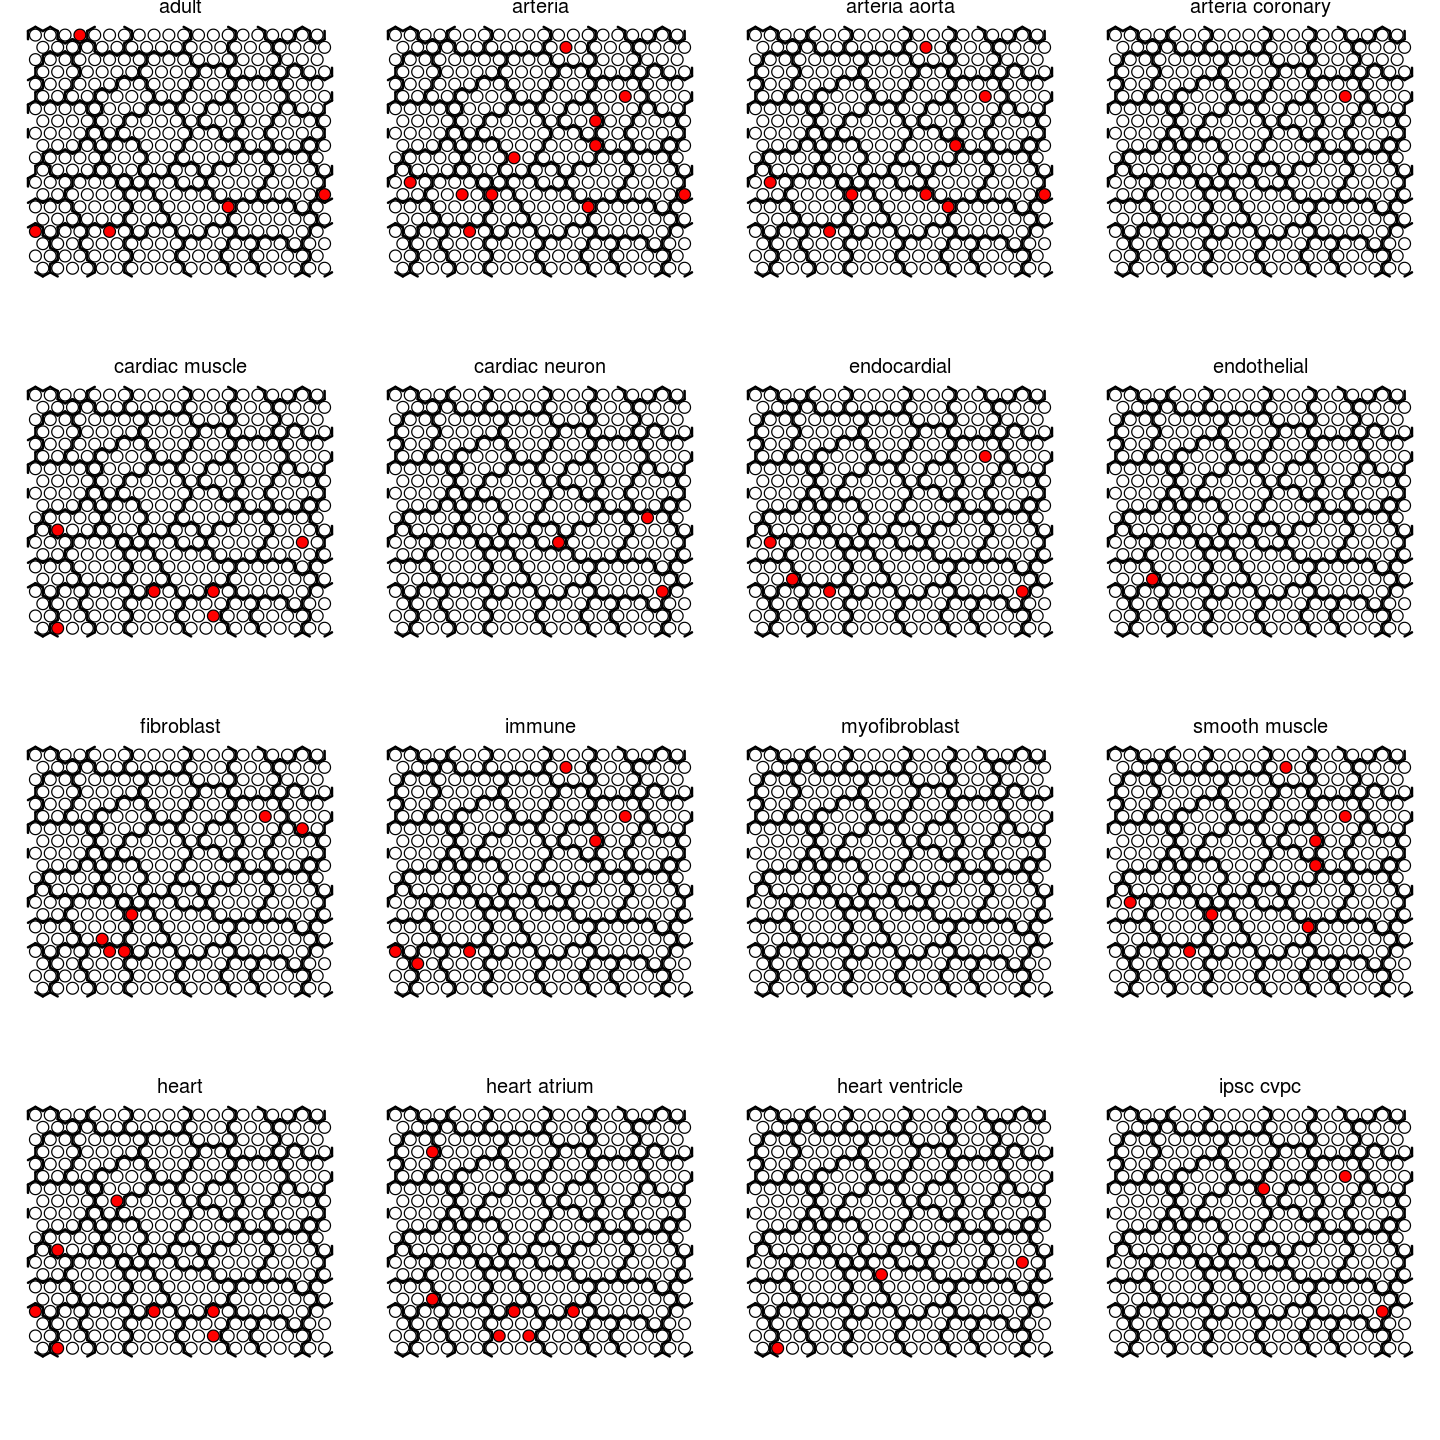

In [266]:
figure_som_cell = function(cell)
{
    map          = moloc_map_list[["som"]][["map"     ]]
    g            = moloc_map_list[["som"]][["som_grid"]]
    clusters     = moloc_map_list[["som"]][["clusters"]]
    this         = totest_map[ totest_map$cell == cell,]
    grid         = as.data.frame(g[["pts"]])
    grid$order   = 1:nrow(grid)
    grid$class   = paste0("V", grid$order)
    toplot       = merge(grid, this, all.x = TRUE)
    toplot       = toplot[order(toplot$order),]
    toplot$log2r = log2(toplot$observed / toplot$expected)
    toplot$val   = unlist(lapply(toplot$log2r, function(x){ifelse(is.na(x), yes = 0, no = min(c(max(c(x, -3)), 3)))}))
    toplot$color = "#ffffff"
    toplot[is.na(toplot$qval_emp) == FALSE & toplot$qval_emp <= 0.05, "color"] = "#ff0000"
    #toplot$color = values2color(toplot$val,colorscale = diverge_hcl(n = 100, palette = "Blue-Red 3", rev = TRUE), minval = -3, maxval = 3)
         
    par(mar = c(1,1,1,1))
    plot(1,1, type = "n", xlim = c(min(toplot$x) - 0.5, max(toplot$x) + 0.5), ylim = c(min(toplot$y) - 4.5, max(toplot$y) + 0.5), axes = FALSE)

    points(x = toplot$x, y = toplot$y, cex = 2, pch = 21, bg = toplot$color)
    add.cluster.boundaries(map, clusters, lwd = 2)  

    name = gsub("cibersort.regular.", "", gsub("_", " ", cell))

    mtext(text = name, side = 3, line =  0)
}


options(repr.plot.width = 12, repr.plot.height = 12)

layout(matrix(1:16, nrow = 4, byrow = TRUE))

cell = "heart"
invisible(lapply(cells, figure_som_cell))

#figure_som_cell(cell)

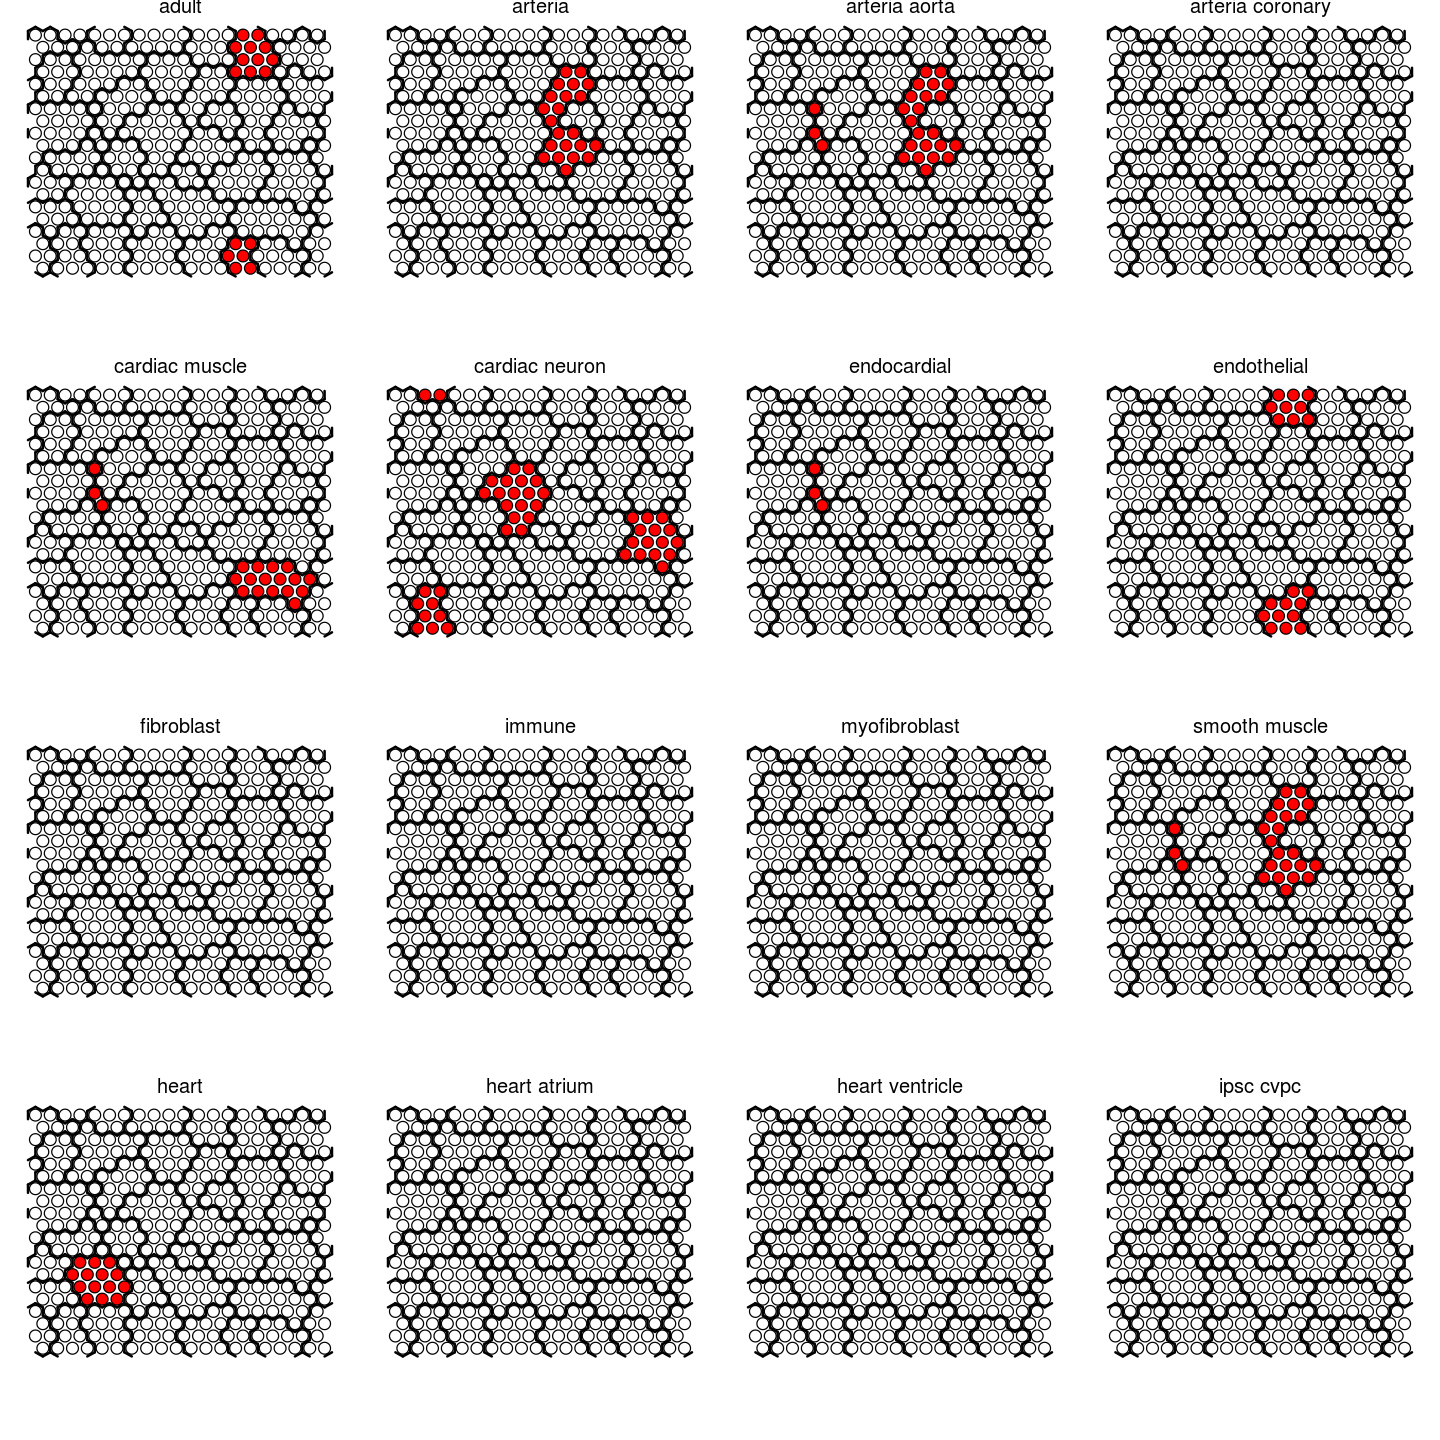

In [267]:
figure_som_cluster_cell = function(cell)
{
    map          = moloc_map_list[["som"]][["map"     ]]
    g            = moloc_map_list[["som"]][["som_grid"]]
    clusters     = moloc_map_list[["som"]][["clusters"]]
    this         = totest_cluster[ totest_cluster$cell == cell,]
    this         = merge(this, data.frame(cluster = as.numeric(clusters), class = names(clusters)))
    grid         = as.data.frame(g[["pts"]])
    grid$order   = 1:nrow(grid)
    grid$class   = paste0("V", grid$order)
    toplot       = merge(grid, this, all.x = TRUE)
    toplot       = toplot[order(toplot$order),]
    toplot$log2r = log2(toplot$observed / toplot$expected)
    toplot$val   = unlist(lapply(toplot$log2r, function(x){ifelse(is.na(x), yes = 0, no = min(c(max(c(x, -3)), 3)))}))
    toplot$color = "#ffffff"
    toplot[is.na(toplot$qval_emp) == FALSE & toplot$qval_emp <= 0.05, "color"] = "#ff0000"
    #toplot$color = values2color(toplot$val,colorscale = diverge_hcl(n = 100, palette = "Blue-Red 3", rev = TRUE), minval = -3, maxval = 3)
         
    par(mar = c(1,1,1,1))
    plot(1,1, type = "n", xlim = c(min(toplot$x) - 0.5, max(toplot$x) + 0.5), ylim = c(min(toplot$y) - 4.5, max(toplot$y) + 0.5), axes = FALSE)

    points(x = toplot$x, y = toplot$y, cex = 2, pch = 21, bg = toplot$color)
    add.cluster.boundaries(map, clusters, lwd = 2)  

    name = gsub("cibersort.regular.", "", gsub("_", " ", cell))

    mtext(text = name, side = 3, line =  0)
}


options(repr.plot.width = 12, repr.plot.height = 12)

layout(matrix(1:16, nrow = 4, byrow = TRUE))

cell = "heart"
invisible(lapply(cells, figure_som_cluster_cell))

#figure_som_cluster_cell(cell)

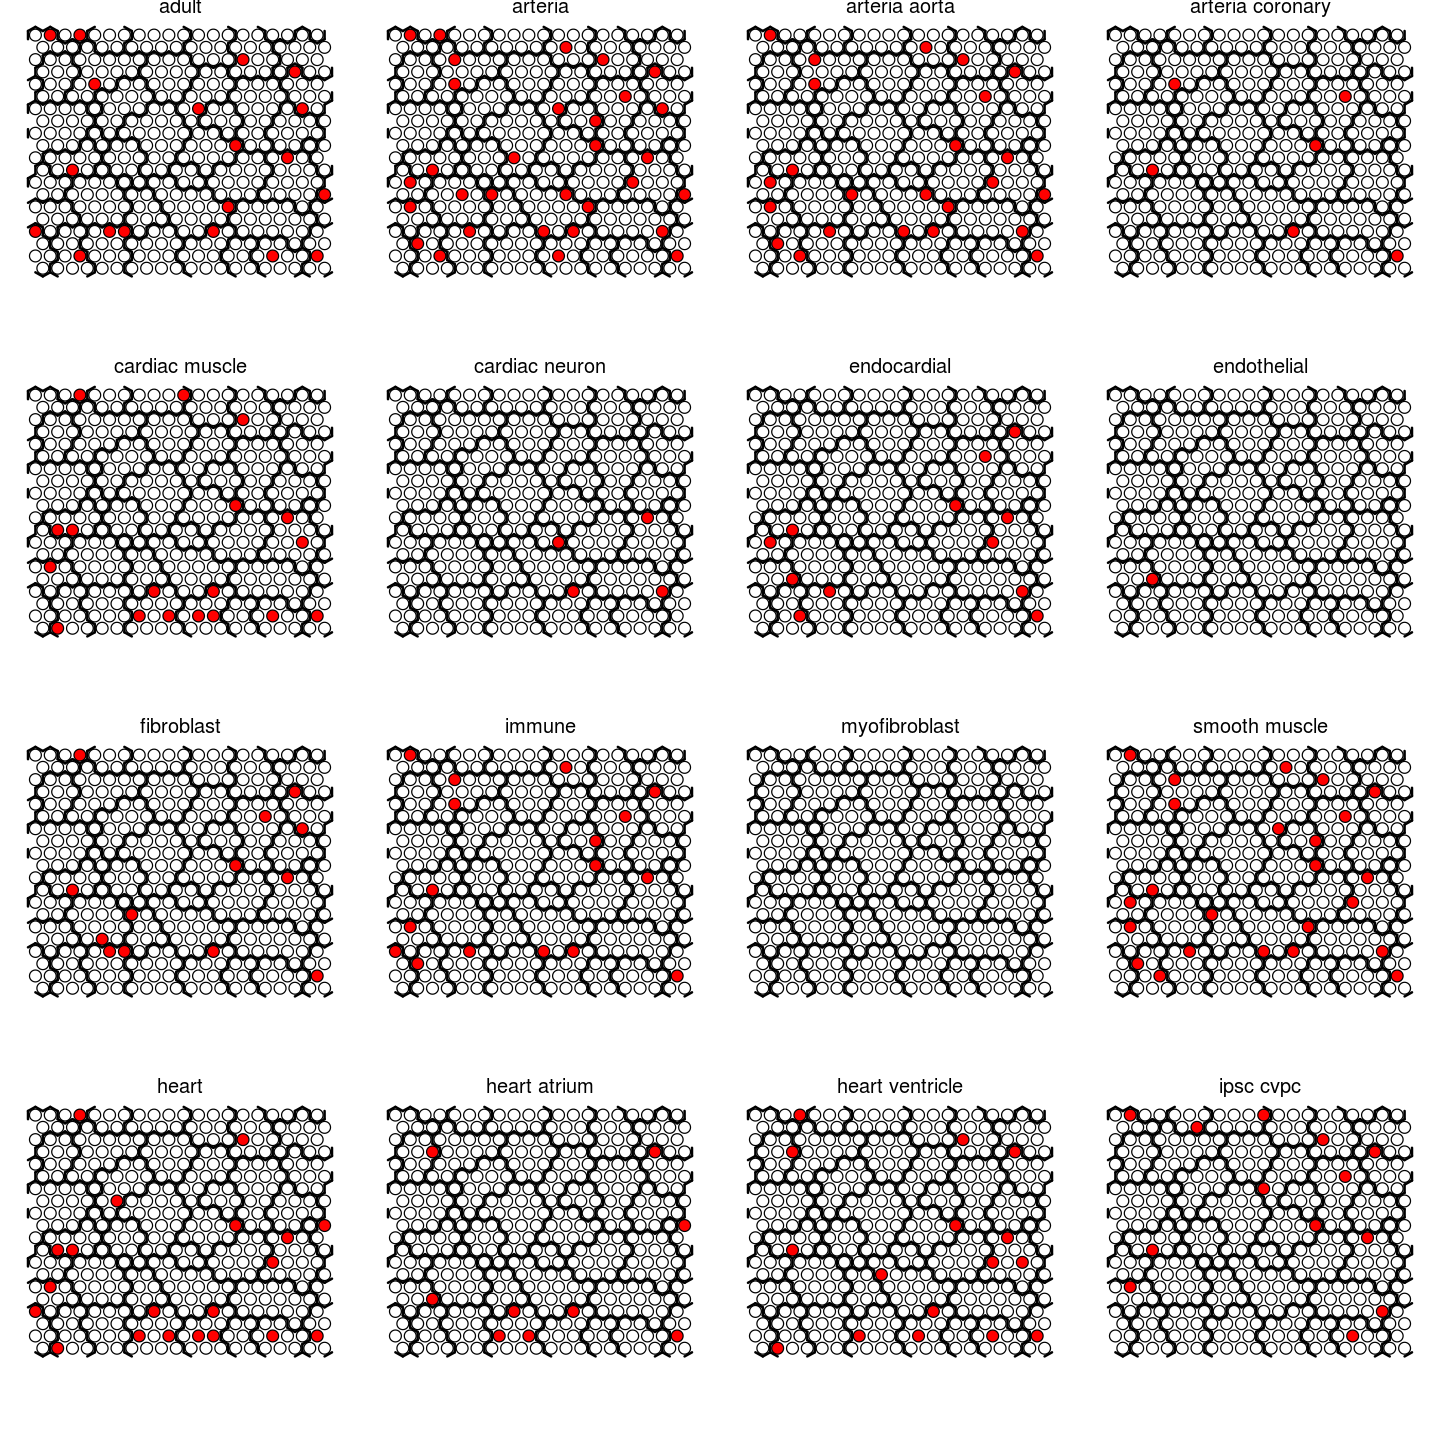

In [276]:
figure_som_cell = function(cell)
{
    map          = moloc_map_list[["som"]][["map"     ]]
    g            = moloc_map_list[["som"]][["som_grid"]]
    clusters     = moloc_map_list[["som"]][["clusters"]]
    this         = signal2int
    this$cell    = this[,cell]
    this         = aggregate(cell ~ class, data = this, function(x){ifelse(length(x[x == TRUE]) > 0, yes = TRUE, no = FALSE)})
    grid         = as.data.frame(g[["pts"]])
    grid$order   = 1:nrow(grid)
    grid$class   = paste0("V", grid$order)
    toplot       = merge(grid, this, all.x = TRUE)
    toplot       = toplot[order(toplot$order),]
    toplot$color = "#ffffff"
    toplot[is.na(toplot$cell) == TRUE, "cell" ] = FALSE
    toplot[      toplot$cell  == TRUE, "color"] = "#ff0000"
    #toplot$color = values2color(toplot$val,colorscale = diverge_hcl(n = 100, palette = "Blue-Red 3", rev = TRUE), minval = -3, maxval = 3)
         
    par(mar = c(1,1,1,1))
    plot(1,1, type = "n", xlim = c(min(toplot$x) - 0.5, max(toplot$x) + 0.5), ylim = c(min(toplot$y) - 4.5, max(toplot$y) + 0.5), axes = FALSE)

    points(x = toplot$x, y = toplot$y, cex = 2, pch = 21, bg = toplot$color)
    add.cluster.boundaries(map, clusters, lwd = 2)  

    name = gsub("cibersort.regular.", "", gsub("_", " ", cell))

    mtext(text = name, side = 3, line =  0)
}


options(repr.plot.width = 12, repr.plot.height = 12)

layout(matrix(1:16, nrow = 4, byrow = TRUE))

cell = "heart"
invisible(lapply(cells, figure_som_cell))

#figure_som_cell(cell)

In [272]:
cell      = "heart"
this      = signal2int
this$cell = this[,cell]
this      = aggregate(cell ~ class, data = this, function(x){ifelse(length(x[x == TRUE]) > 0, yes = TRUE, no = FALSE)})

# Find example:
- figure 1: locus with multiple signals
- figure 2: fine mapping of at least one of the signals goes down a single or few variants
- figure 3: different eQTL signals for gene and isoform
- figure 4: one of the signals is associated with gene eQTL and another signal to the eIsoform

In [51]:
coloc_eqtls[ coloc_eqtls$signal_id == "1_965800_2544414.2" & coloc_eqtls$PP.H4.abf >= 0.8,]
eqtls_gene [ eqtls_gene$transcript_id == "ENSG00000205090.9_5",]


som signal_id          locus            cluster class transcript_id      
1640 198 1_965800_2544414.2 1_965800_2544414 21      V198  ENSG00000205090.9_5
     gene_id             gene_name type phenotype nsnps PP.H0.abf    PP.H1.abf 
1640 ENSG00000205090.9_5 TMEM240   0    rna       1690  2.635016e-11 0.02958624
     PP.H2.abf    PP.H3.abf PP.H4.abf id                pp_snp   
1640 1.446183e-10 0.1615701 0.8088436 VAR_1_1489928_T_C 0.2274959

id                transcript_id       gene_id             gene_name
750 VAR_1_1507366_G_A ENSG00000205090.9_5 ENSG00000205090.9_5 TMEM240  
    gene_type      start   end     strand chrom pos     ⋯ type qval       
750 protein_coding 1470158 1476004 -      1     1507366 ⋯ 0    0.002014507
    egene distance annotation.atac annotation.body annotation.chip
750 TRUE  -31362   FALSE           TRUE            FALSE          
    annotation.exon self.body self.exon
750 FALSE           FALSE     FALSE

In [154]:
find_example = function (signal_id) 
{
    x = locus2coloc[locus2coloc$id == signal_id, c("id", "locus", "class", "cluster", "traits", "finemapped", "credible_set", "cs_from", "cs_to")]
    
    x$multi_signal_locus         = FALSE
    x$finemapped_10              = FALSE
    x$has_eqtls                  = FALSE
    x$has_eqtls_cell             = FALSE
    x$has_eqtls_gene             = FALSE
    x$has_eqtls_isoform          = FALSE
    x$is_eqtls_pph3_gene_isoform = FALSE
    x$eqtls_gene                 = ""
    x$eqtls_isoform              = ""
    x$eqtls_pph3_gene_isoform    = ""
    locus                        = x$locus
    this_coloc_eqtls             = coloc_eqtls[coloc_eqtls$signal_id == signal_id & coloc_eqtls$PP.H4.abf >= 0.8, ]
    this_coloc_eqtls$tr2type     = paste(this_coloc_eqtls$transcript_id , this_coloc_eqtls$type , sep = ":")
    this_coloc_eqtls             = merge(this_coloc_eqtls, qtl_cell, all.x = TRUE)
    
    if (nrow(locus2coloc[locus2coloc$locus == locus, ]) > 1) {x$multi_signal_locus = TRUE}
    if ((x$finemapped == TRUE) & (x$credible_set <= 10))     {x$finemapped_10 = TRUE}
    
    if (nrow(this_coloc_eqtls)                                                     > 0) {x$has_eqtls         = TRUE}
    if (nrow(this_coloc_eqtls[is.na(this_coloc_eqtls$interaction) == FALSE    , ]) > 0) {x$has_eqtls_cell    = TRUE}
    if (nrow(this_coloc_eqtls[      this_coloc_eqtls$phenotype    == "rna"    , ]) > 0) {x$has_eqtls_gene    = TRUE}
    if (nrow(this_coloc_eqtls[      this_coloc_eqtls$phenotype    == "isoform", ]) > 0) {x$has_eqtls_isoform = TRUE}
    
    x$eqtls_gene    = paste0(this_coloc_eqtls[this_coloc_eqtls$phenotype == "rna"    , "transcript_id"], ":", 
                             this_coloc_eqtls[this_coloc_eqtls$phenotype == "rna"    , "type"         ], " (", 
                             this_coloc_eqtls[this_coloc_eqtls$phenotype == "rna"    , "gene_name"    ], ": ",
                             this_coloc_eqtls[this_coloc_eqtls$phenotype == "rna"    , "interaction"  ], ")", collapse = "; ")
    x$eqtls_isoform = paste0(this_coloc_eqtls[this_coloc_eqtls$phenotype == "isoform", "transcript_id"], ":", 
                             this_coloc_eqtls[this_coloc_eqtls$phenotype == "isoform", "type"         ], " (", 
                             this_coloc_eqtls[this_coloc_eqtls$phenotype == "isoform", "gene_name"    ], ": ",
                             this_coloc_eqtls[this_coloc_eqtls$phenotype == "isoform", "interaction"  ], ")", collapse = "; ")
    
    
    this_eqtls_coloc          = eqtl_coloc [ (eqtl_coloc$transcript_id1 %in% this_coloc_eqtls$transcript_id | eqtl_coloc$transcript_id2 %in% this_coloc_eqtls$transcript_id) & (eqtl_coloc$PP.H3.abf >= 0.8 | eqtl_coloc$PP.H4.abf >= 0.8),]
    
    if(x$eqtls_gene    == ": (: )"){x$eqtls_gene    = ""}
    if(x$eqtls_isoform == ": (: )"){x$eqtls_isoform = ""}
    
    if((nrow(this_eqtls_coloc) > 0) & (x$eqtls_gene != "") & (x$eqtls_isoform != ""))
    {
        this_eqtls_coloc$tr2type1 = paste(this_eqtls_coloc$transcript_id1, this_eqtls_coloc$type1, sep = ":")
        this_eqtls_coloc$tr2type2 = paste(this_eqtls_coloc$transcript_id2, this_eqtls_coloc$type2, sep = ":")
        this_eqtls_coloc          = this_eqtls_coloc[(this_eqtls_coloc$tr2type1 %in% this_coloc_eqtls$tr2type | this_eqtls_coloc$tr2type2 %in% this_coloc_eqtls$tr2type) & 
                                                     grepl("ENST", this_eqtls_coloc$transcript_id1) == TRUE &
                                                     grepl("ENSG", this_eqtls_coloc$transcript_id2) == TRUE &
                                                     this_eqtls_coloc$PP.H3.abf >= 0.8, ]
        
        if(nrow(this_eqtls_coloc) > 0)
        {
            x$is_eqtls_pph3_gene_isoform = TRUE
            x$eqtls_pph3_gene_isoform    = paste0(this_eqtls_coloc$tr2type1, ", ", this_eqtls_coloc$tr2type2, collapse = "; ")
        }
    }
    
    return(x)
}

examples = as.data.frame(rbindlist(lapply(locus2coloc$id, find_example)), stringsAsFactors = FALSE)

fwrite(examples, "pipeline/5.5.meta_analysis/examples.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [155]:
table(examples$has_eqtls)

has_eqtls = sort(unique(coloc_eqtls[ coloc_eqtls$PP.H4.abf >= 0.8, "signal_id"]))

examples[ examples$id %in% has_eqtls & examples$has_eqtls == FALSE, ]


FALSE  TRUE 
 2704   722 

id locus class cluster traits finemapped credible_set cs_from cs_to
     multi_signal_locus finemapped_10 has_eqtls has_eqtls_cell has_eqtls_gene
     has_eqtls_isoform is_eqtls_pph3_gene_isoform eqtls_gene eqtls_isoform
     eqtls_pph3_gene_isoform

# Example 1: 16_1661864_2933479


In [77]:
locus      = "16_1661864_2933479"
signal_ids = locus2coloc[ locus2coloc$locus == locus, "id"]


In [79]:
locus = "16_1661864_2933479"

this_locus       = locus2coloc[ locus2coloc$locus == locus, c("id", "class", "cluster", "traits", "finemapped", "credible_set", "cs_from", "cs_to")]
this_coloc_eqtls = coloc_eqtls[ coloc_eqtls$locus == locus & coloc_eqtls$PP.H4.abf >= 0.8, ]
this_eqtls_coloc = eqtl_coloc [ (eqtl_coloc$transcript_id1 %in% this_coloc_eqtls$transcript_id | eqtl_coloc$transcript_id2 %in% this_coloc_eqtls$transcript_id) & (eqtl_coloc$PP.H3.abf >= 0.8 | eqtl_coloc$PP.H4.abf >= 0.8),]

this_locus
this_coloc_eqtls[ order(this_coloc_eqtls$signal_id, -this_coloc_eqtls$PP.H4.abf),]

this_eqtls_coloc[ this_eqtls_coloc$PP.H3.abf >= 0.8,]
this_eqtls_coloc[ this_eqtls_coloc$PP.H4.abf >= 0.8,]


id                   class cluster
2823 16_1661864_2933479.4 V73   19     
2824 16_1661864_2933479.6 V32   28     
2825 16_1661864_2933479.1 V272  16     
2826 16_1661864_2933479.3 V40   15     
2827 16_1661864_2933479.5 V384   2     
2828 16_1661864_2933479.2 V220   6     
     traits                                                                                                                                                                                       
2823 continuous-102-both_sexes-irnt                                                                                                                                                               
2824 icd10-I48-both_sexes                                                                                                                                                                         
2825 continuous-DBP-both_sexes-combined_medadj_irnt; continuous-MAP-both_sexes-combined_medadj_irnt; continuous-PP-both_sexes-combined_medadj_irnt; continuous-SBP-both_sexes-combined_medadj_irnt
2826 biomarkers-30870-both_sexes-irnt                                                                                                                                                             
2827 continuous-LDLC-both_sexes-medadj_irnt                                                                                                                                                       
2828 biomarkers-30760-both_sexes-irnt; continuous-21001-both_sexes-irnt                                                                                                                           
     finemapped credible_set cs_from cs_to  
2823 TRUE       119          1664041 2200184
2824 TRUE         1          2003016 2003016
2825 TRUE         1          2158570 2158570
2826 TRUE       113          2439327 2502641
2827 TRUE         1          2674462 2674462
2828 TRUE         1          2709740 2709740

som signal_id            locus              cluster class
39430 40  16_1661864_2933479.3 16_1661864_2933479 15      V40  
39131 73  16_1661864_2933479.4 16_1661864_2933479 19      V73  
39246 32  16_1661864_2933479.6 16_1661864_2933479 28      V32  
39245 32  16_1661864_2933479.6 16_1661864_2933479 28      V32  
39283 32  16_1661864_2933479.6 16_1661864_2933479 28      V32  
39282 32  16_1661864_2933479.6 16_1661864_2933479 28      V32  
39231 32  16_1661864_2933479.6 16_1661864_2933479 28      V32  
      transcript_id        gene_id              gene_name  type phenotype nsnps
39430 ENSG00000162066.15_5 ENSG00000162066.15_5 AMDHD2     0    rna        811 
39131 ENSG00000206053.13_8 ENSG00000206053.13_8 JPT2       1    rna       1496 
39246 ENSG00000184207.9_6  ENSG00000184207.9_6  PGP        0    rna       1800 
39245 ENSG00000261532.1_7  ENSG00000261532.1_7  AC009065.8 0    rna       1799 
39283 ENST00000533186.5_7  ENSG00000140988.16_8 RPS2       0    isoform   1808 
39282 ENST00000343262.9_3  ENSG00000140988.16_8 RPS2       0    isoform   1808 
39231 ENSG00000140990.15_6 ENSG00000140990.15_6 NDUFB10    0    rna       1807 
      PP.H0.abf    PP.H1.abf    PP.H2.abf    PP.H3.abf   PP.H4.abf
39430 8.336383e-06 2.033784e-03 0.0003219675 0.077628727 0.9200072
39131 1.585837e-06 4.209732e-04 0.0004802768 0.126620870 0.8724763
39246 2.969056e-09 4.938646e-09 0.0011170081 0.000859977 0.9980230
39245 3.971744e-04 6.606476e-04 0.0062538868 0.009419252 0.9832690
39283 5.356387e-52 8.909838e-52 0.0084104769 0.013011446 0.9785781
39282 1.463349e-47 2.434141e-47 0.0084269442 0.013038882 0.9785342
39231 4.871935e-06 8.103959e-06 0.0119817482 0.018961352 0.9690439
      id                 pp_snp   
39430 VAR_16_2462739_C_T 0.4950801
39131 VAR_16_1768227_T_C 0.1716285
39246 VAR_16_2265271_C_T 0.9999181
39245 VAR_16_2265271_C_T 0.9987522
39283 VAR_16_2014283_A_G 0.9901921
39282 VAR_16_2014283_A_G 0.9880300
39231 VAR_16_2011126_A_G 0.4095353

nsnps PP.H0.abf    PP.H1.abf    PP.H2.abf    PP.H3.abf PP.H4.abf   
9727 2438  1.365345e-46 7.372207e-02 1.664886e-45 0.8989310 2.734694e-02
9728 2438  1.072850e-51 5.792874e-07 1.852016e-45 0.9999994 2.548433e-08
9732 2438  5.295883e-51 7.389573e-02 6.457738e-50 0.9010509 2.505342e-02
9733 2438  4.151577e-56 5.792874e-07 7.166692e-50 0.9999994 2.424672e-08
     transcript_id1      transcript_id2       type1 type2 id                
9727 ENST00000343262.9_3 ENSG00000140988.16_8 0     0     VAR_16_2014283_A_G
9728 ENST00000343262.9_3 ENSG00000140988.16_8 0     1     VAR_16_2014283_A_G
9732 ENST00000533186.5_7 ENSG00000140988.16_8 0     0     VAR_16_2014283_A_G
9733 ENST00000533186.5_7 ENSG00000140988.16_8 0     1     VAR_16_2014283_A_G
     af   chrom pos     ref alt pval1        pval2      pp_snp   
9727 0.83 16    2014283 A   G   3.105981e-59 0.03111299 0.6545243
9728 0.83 16    2014283 A   G   3.105981e-59 1.00000000 0.7510705
9732 0.83 16    2014283 A   G   2.054311e-64 0.03111299 0.7463710
9733 0.83 16    2014283 A   G   2.054311e-64 1.00000000 0.8227470

nsnps PP.H0.abf    PP.H1.abf    PP.H2.abf    PP.H3.abf    PP.H4.abf
9726 2438  1.634971e-97 8.828053e-53 2.281345e-48 0.0002320483 0.9997680
9730 2438  2.375455e-03 3.022921e-03 2.896602e-02 0.0359314489 0.9297042
     transcript_id1      transcript_id2       type1 type2 id                 
9726 ENST00000343262.9_3 ENST00000533186.5_7  0     0     VAR_16_2014283_A_G 
9730 ENST00000343262.9_3 ENSG00000140988.16_8 1     0     VAR_16_2013660_TC_T
     af   chrom pos     ref alt pval1        pval2        pp_snp   
9726 0.83 16    2014283 A   G   3.105981e-59 2.054311e-64 0.9903037
9730 0.08 16    2013660 TC  T   6.833622e-06 5.243957e-07 0.1906290

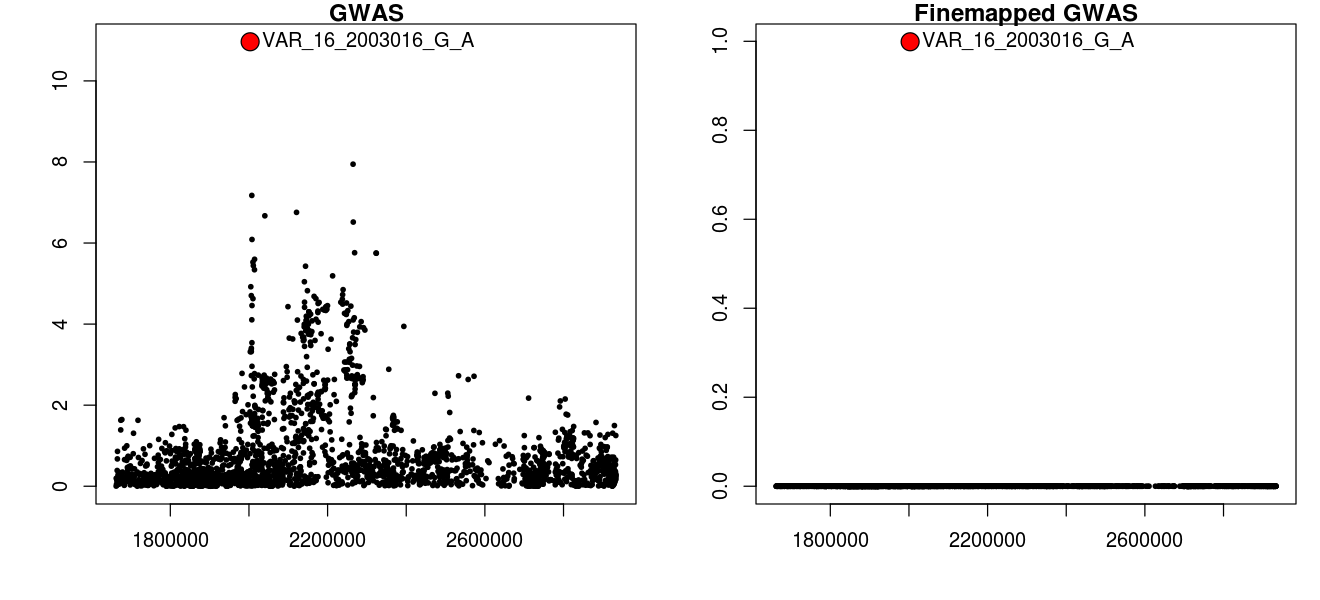

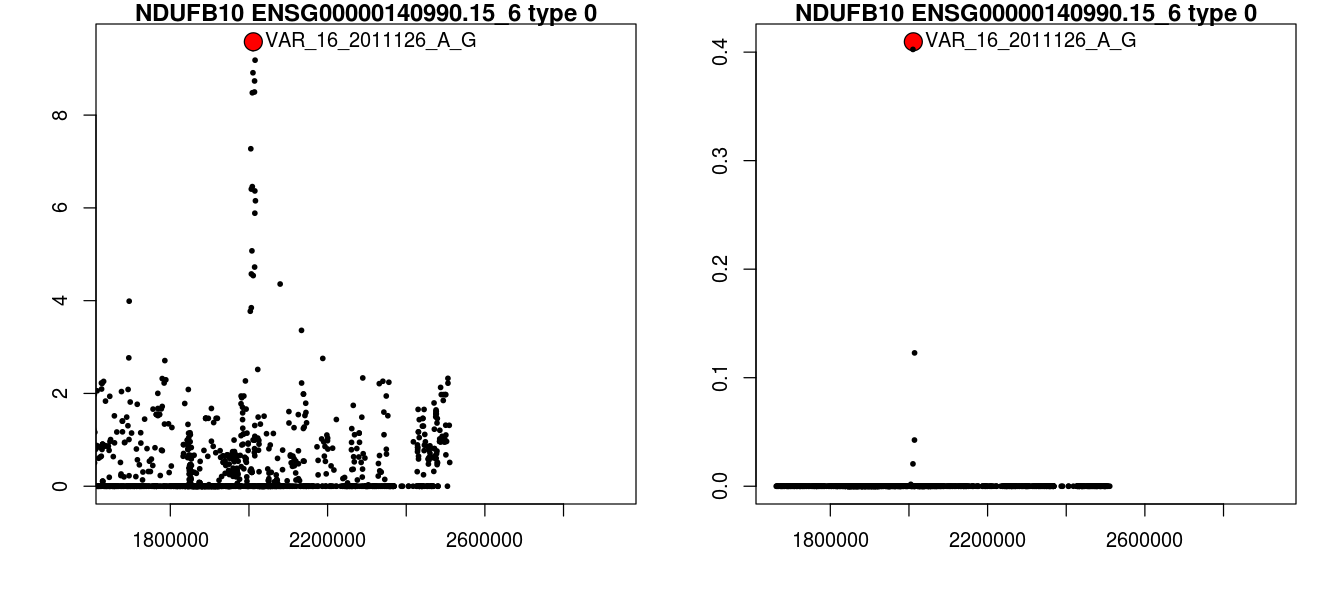

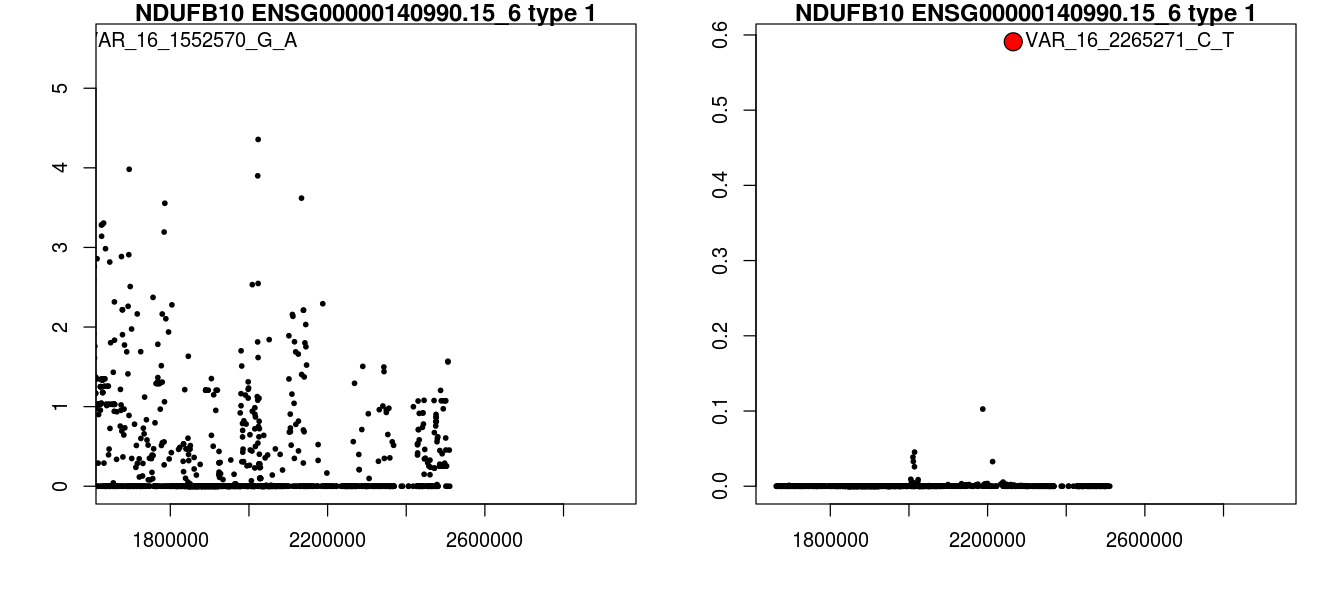

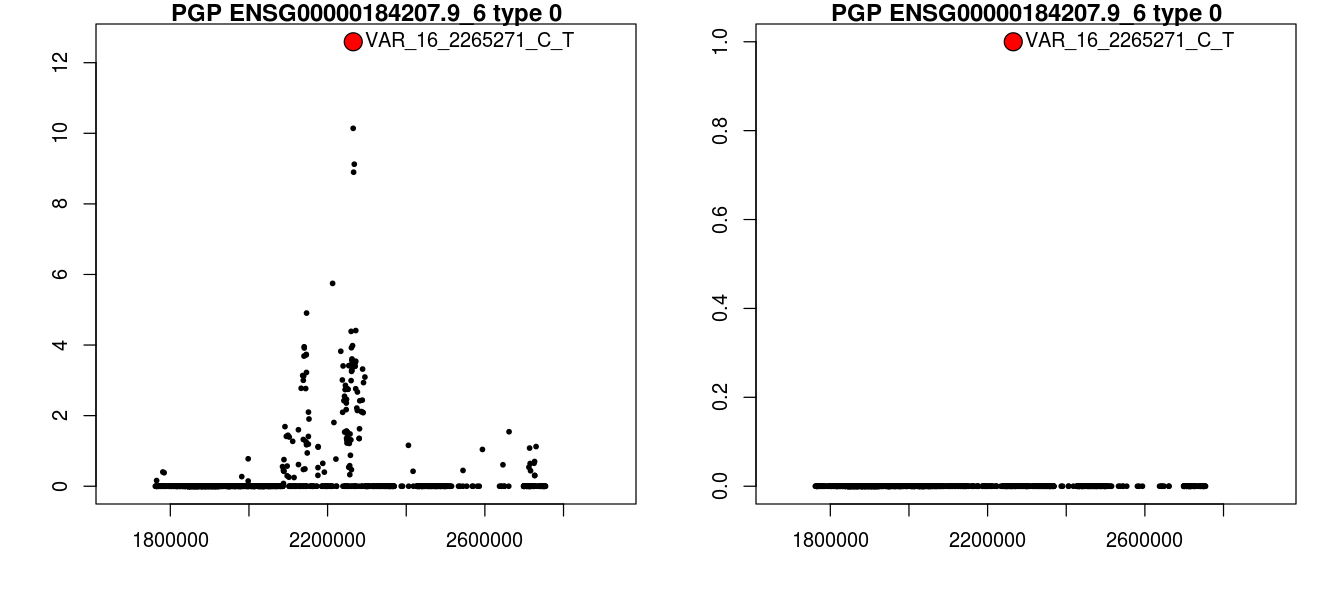

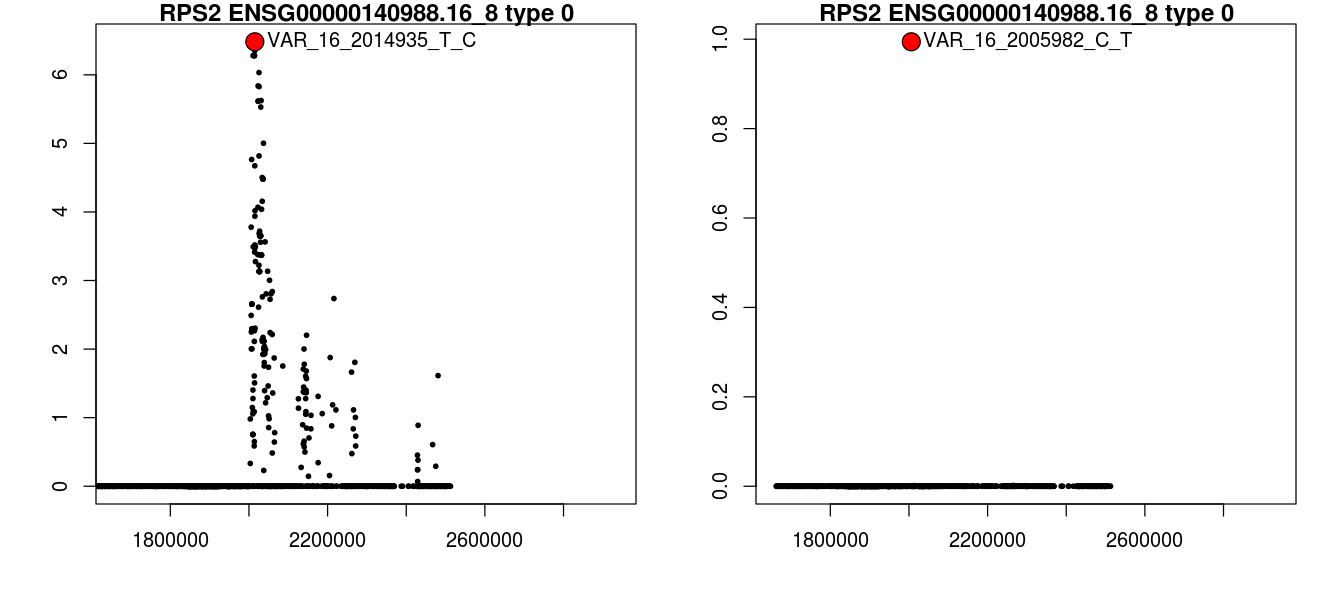

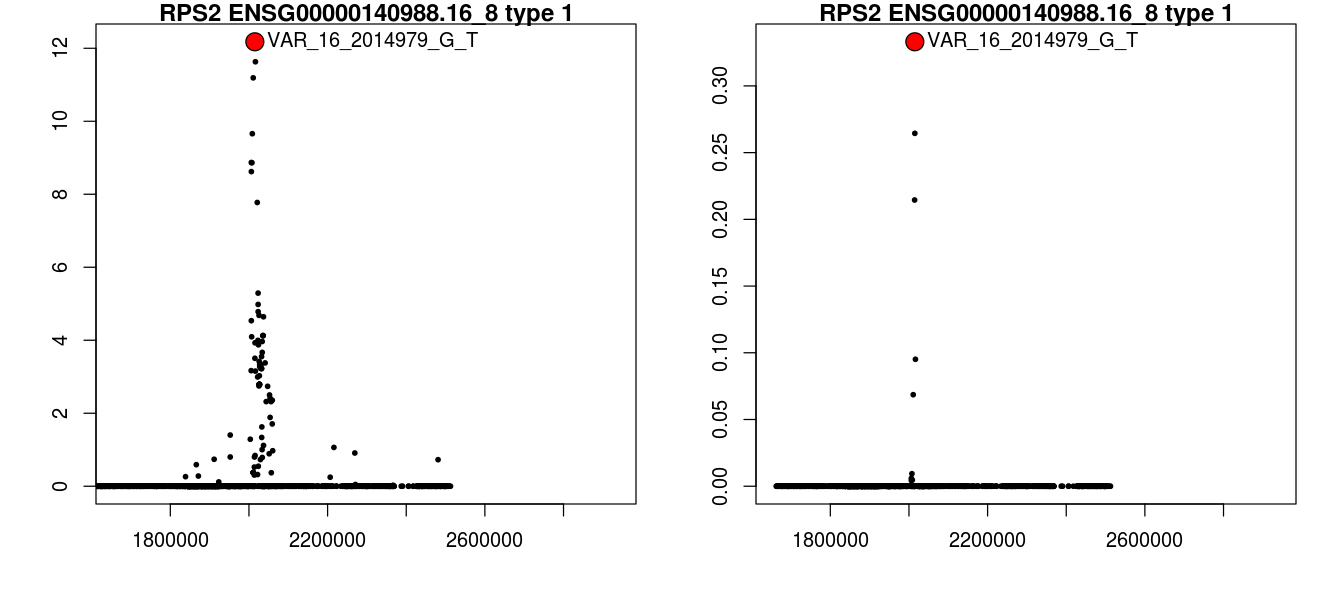

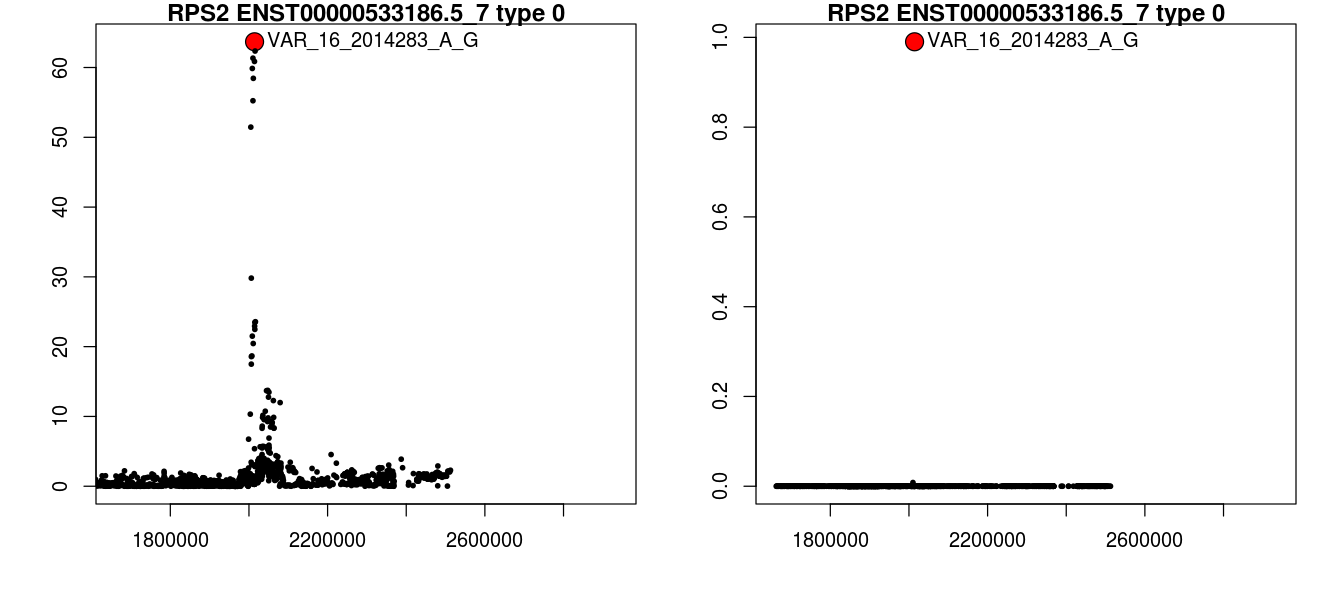

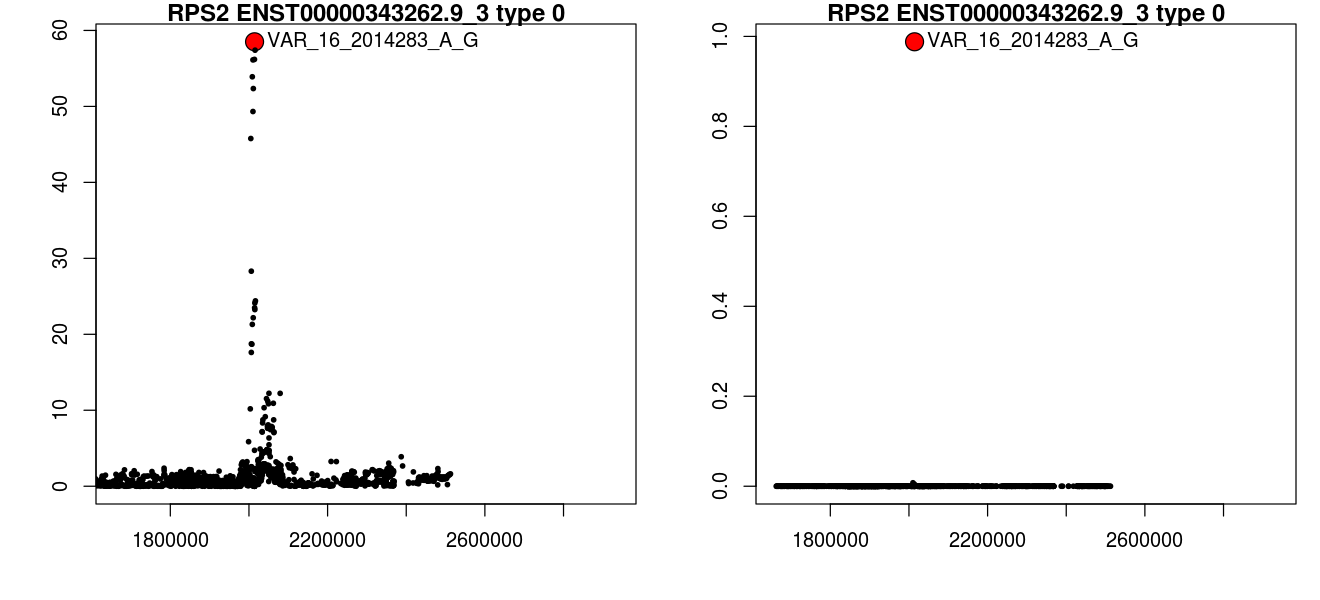

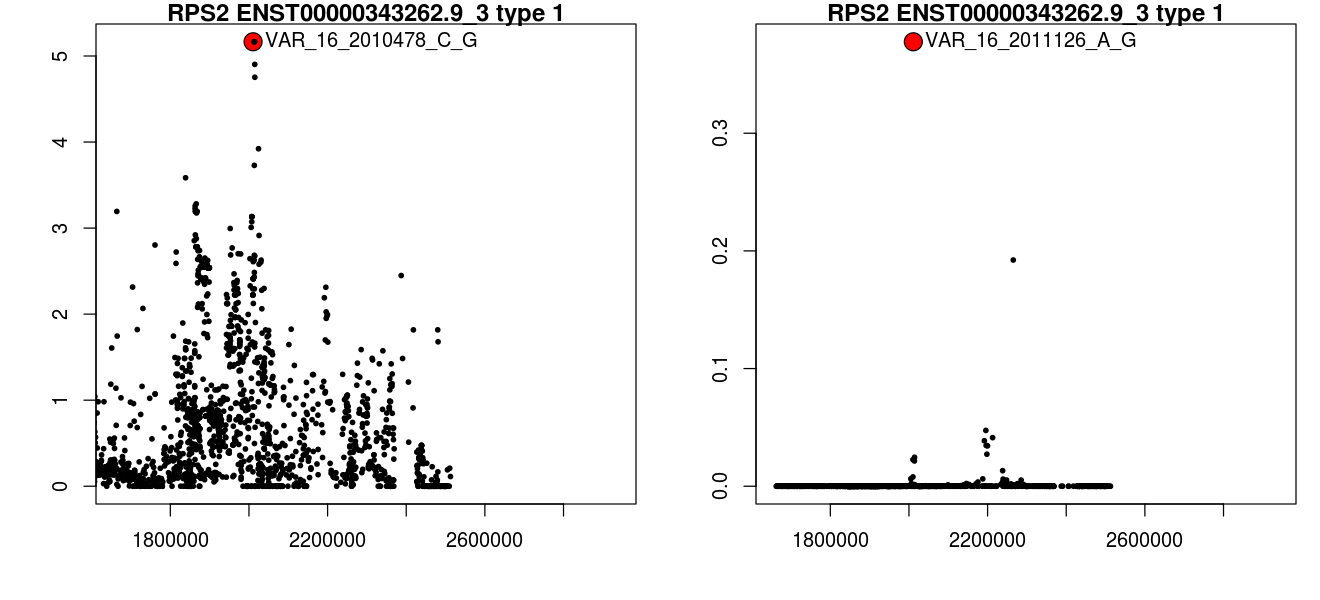

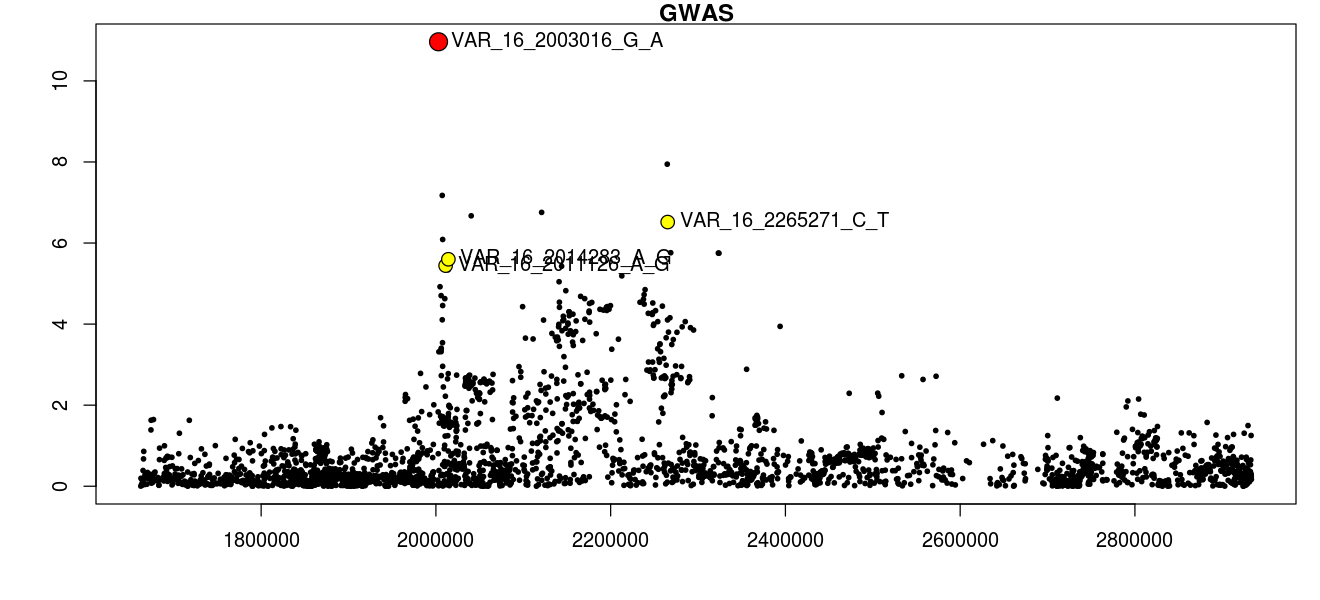

In [133]:
plot_data = function(indata, type, xlims, name, snps = NULL)
{
    toplot      = indata
    toplot      = toplot[toplot$id != "null",]
    
    if(type != "eqtl"){toplot$pos  = as.numeric(unlist(lapply(toplot$id, function(x){unlist(strsplit(x, "_"))[[3]]})))}
    
    if(type %in% c("eqtl", "gwas"))
    {
        toplot$y = -log10(toplot$pval)
    }else
    {
        toplot$y = toplot$pp_snp
    }
    
    toplot$cex = 0.5
    toplot$bg  = "#000000"
    
    toplot[which.max(toplot$y), "cex"] = 2
    toplot[which.max(toplot$y), "bg" ] = "#ff0000"
    
    par(mar = c(4,4,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, max(toplot$y)), xlab = "", ylab = "", axes = TRUE, main = name)
    
    points(x = toplot$pos, y = toplot$y, pch = 21, cex = toplot$cex, bg = toplot$bg)
    
    totext = toplot[which.max(toplot$y),]
    
    text(x = totext[1, "pos"], y = totext[1, "y"], labels = totext[1, "id"], pos = 4)
    
    if(is.null(snps) == FALSE)
    {
        totext = toplot[toplot$id %in% snps[ snps$pph4 >= 0.8, "id"],]
        
        points(x = totext$pos, y = totext$y, cex    = 1.5      , pch = 21, bg  = "#ffff00")
        text  (x = totext$pos, y = totext$y, labels = totext$id, pos = 4)
    }
    
    if(type == "coloc"){return(totext)}
}

plot_example = function(signal_id, transcript_ids)
{
    x     = meta_list[[signal_id]]
    gwas  = x[["meta_analysis_gwas"]]
    fm    = x[["finemapped_gwas"]][["pp"]]
    coloc = x[["coloc"    ]][transcript_ids]
    eqtl  = x[["eqtl_data"]][transcript_ids]
    
    xlims = as.numeric(unlist(strsplit(unlist(strsplit(signal_id, "\\."))[[1]], "_"))[2:3])
    
    options(repr.plot.width = 11, repr.plot.height = 5)
    layout(rbind(1:2))
    plot_data(gwas, "gwas"   , xlims, "GWAS")
    plot_data(fm  , "finemap", xlims, "Finemapped GWAS")
    
    snps = as.data.frame(rbindlist(lapply(transcript_ids, function(transcript_id)
    {
        toplot_fm   = coloc[[transcript_id]]
        toplot_eqtl = eqtl [[transcript_id]]
        
        out = as.data.frame(rbindlist(lapply(names(toplot_fm), function(type)
        {
            plot_data(toplot_eqtl[ toplot_eqtl$type == as.numeric(sub("type ", "", type)), ], "eqtl", xlims, paste(coordinates[ coordinates$transcript_id == transcript_id, "gene_name"], transcript_id, type))
            
            out               = plot_data(toplot_fm[[type]][["by_snp"]], "coloc", xlims, paste(coordinates[ coordinates$transcript_id == transcript_id, "gene_name"], transcript_id, type))
            out$pph4          = toplot_fm[[type]][["pp"]][,"PP.H4.abf"]
            out$type          = type
            out$transcript_id = transcript_id
            
            
            return(out)
        })), stringsAsFactors = FALSE)
        return(out)
    })), stringsAsFactors = FALSE)
    
    layout(rbind(1))
    plot_data(gwas, "gwas"   , xlims, "GWAS", snps)
    return(merge(snps, coordinates[,c("transcript_id", "gene_id", "gene_name", "phenotype")]))
    
    
    #return(coloc)
}    


x = plot_example("16_1661864_2933479.6", c("ENSG00000140990.15_6", "ENSG00000184207.9_6", "ENSG00000140988.16_8", "ENST00000533186.5_7", "ENST00000343262.9_3"))



In [ ]:
rs140185678, rs77316573, rs2286466, rs758335 

In [134]:
x[order(x$pph4, decreasing = TRUE),]

transcript_id        id                 pp_snp    pos     y         cex
5 ENSG00000184207.9_6  VAR_16_2265271_C_T 0.9999181 2265271 0.9999181 2  
8 ENST00000533186.5_7  VAR_16_2014283_A_G 0.9901921 2014283 0.9901921 2  
6 ENST00000343262.9_3  VAR_16_2014283_A_G 0.9880300 2014283 0.9880300 2  
3 ENSG00000140990.15_6 VAR_16_2011126_A_G 0.4095353 2011126 0.4095353 2  
1 ENSG00000140988.16_8 VAR_16_2005982_C_T 0.9942190 2005982 0.9942190 2  
7 ENST00000343262.9_3  VAR_16_2011126_A_G 0.3777150 2011126 0.3777150 2  
4 ENSG00000140990.15_6 VAR_16_2265271_C_T 0.5909319 2265271 0.5909319 2  
2 ENSG00000140988.16_8 VAR_16_2014979_G_T 0.3330761 2014979 0.3330761 2  
  bg      pph4       type   gene_id              gene_name phenotype
5 #ff0000 0.99802301 type 0 ENSG00000184207.9_6  PGP       rna      
8 #ff0000 0.97857808 type 0 ENSG00000140988.16_8 RPS2      isoform  
6 #ff0000 0.97853417 type 0 ENSG00000140988.16_8 RPS2      isoform  
3 #ff0000 0.96904392 type 0 ENSG00000140990.15_6 NDUFB10   rna      
1 #ff0000 0.61380773 type 0 ENSG00000140988.16_8 RPS2      rna      
7 #ff0000 0.03144667 type 1 ENSG00000140988.16_8 RPS2      isoform  
4 #ff0000 0.02899416 type 1 ENSG00000140990.15_6 NDUFB10   rna      
2 #ff0000 0.01330082 type 1 ENSG00000140988.16_8 RPS2      rna

# Example 2: 9_0_339313.1 (iPSC-CVPC, CBWD1: synthesis of vitamin B12, associated with blood pressure; B12 levels are associated with blood pressure)

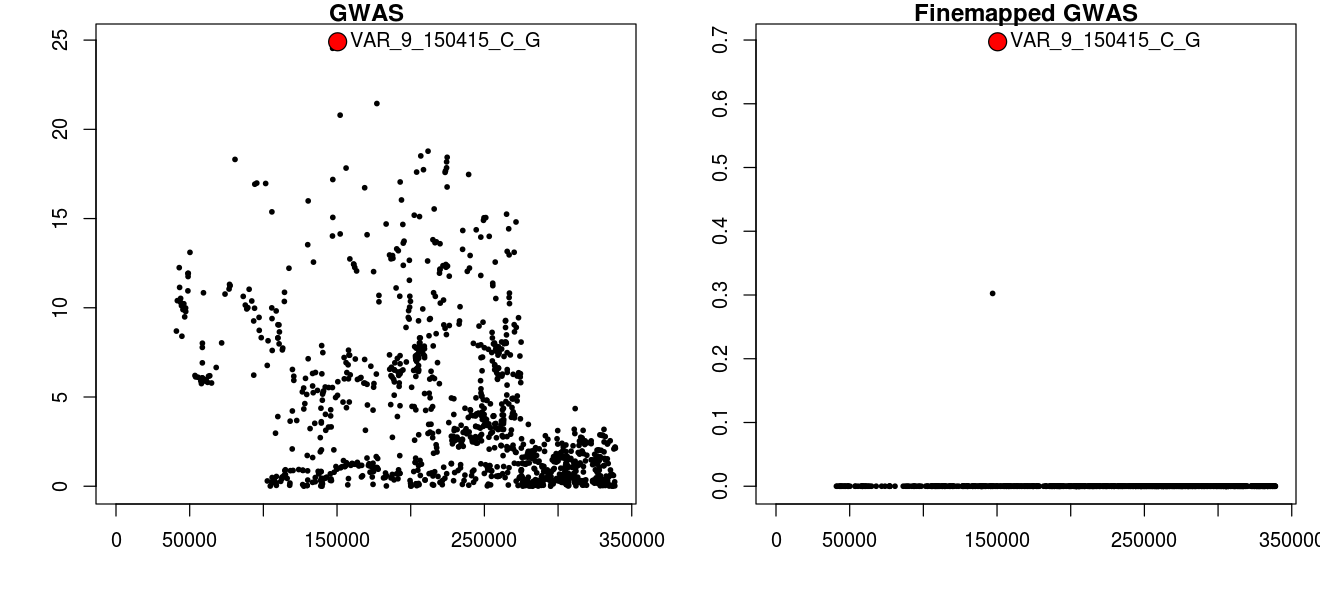

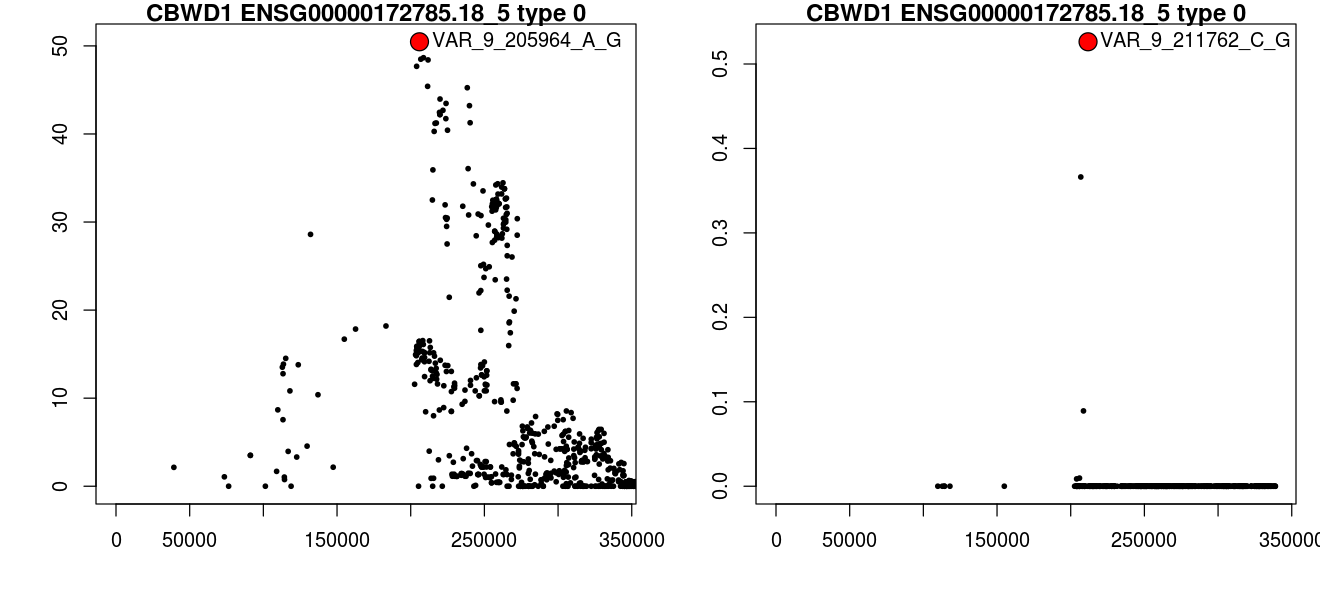

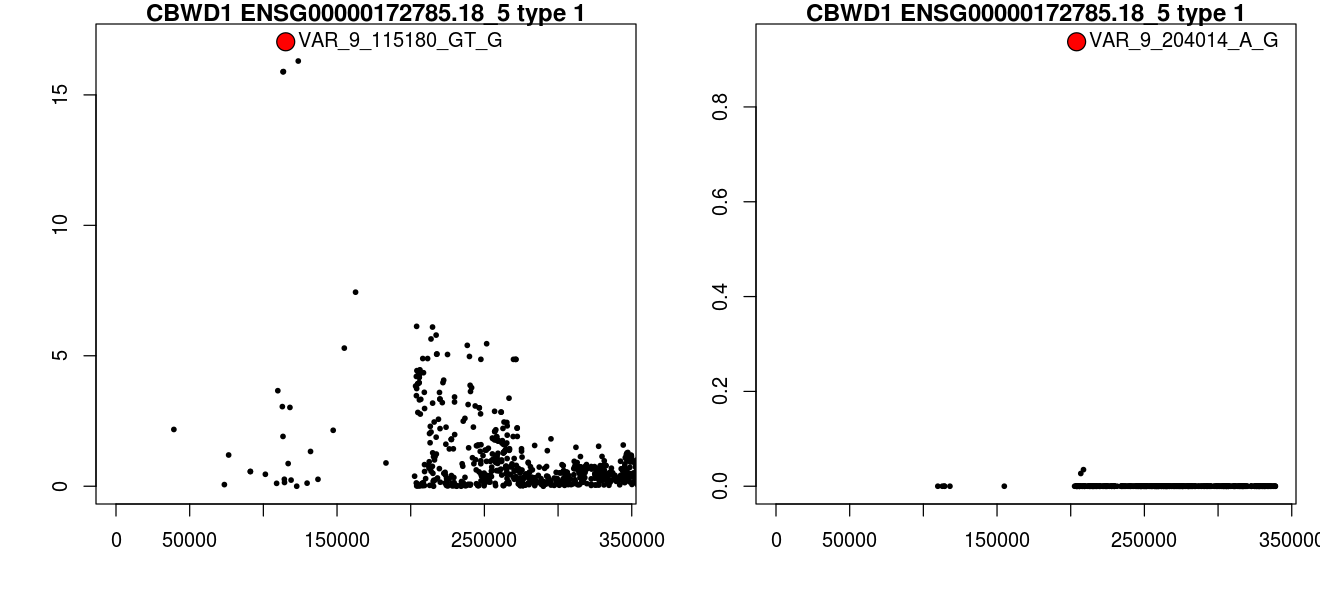

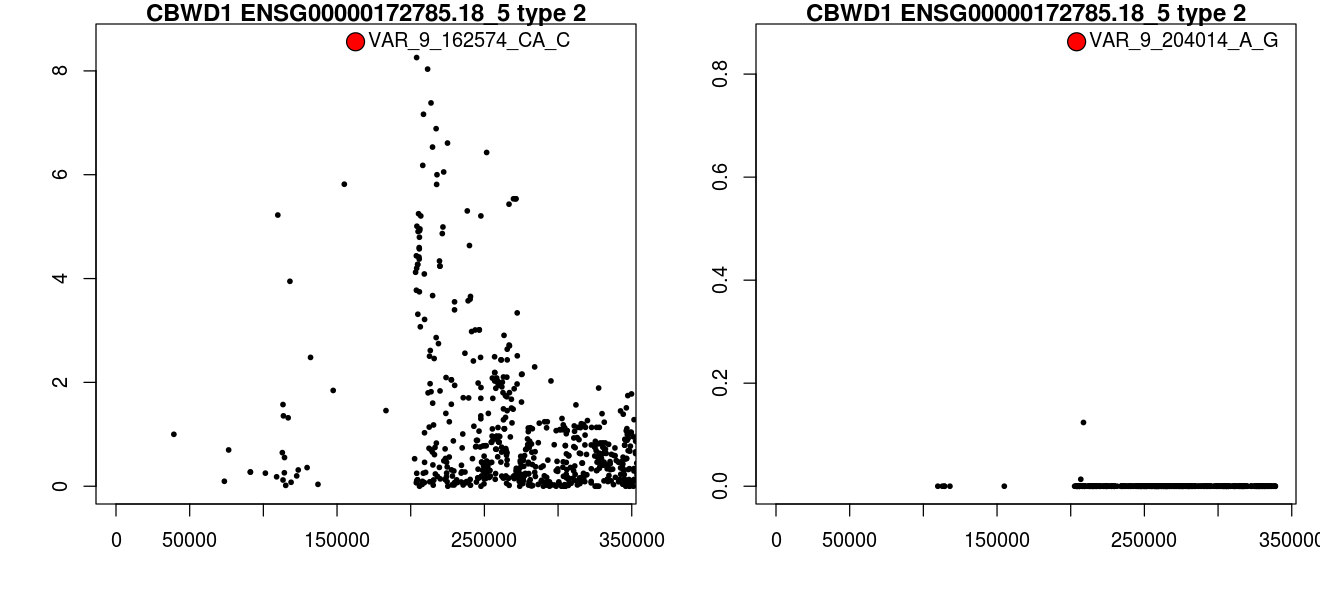

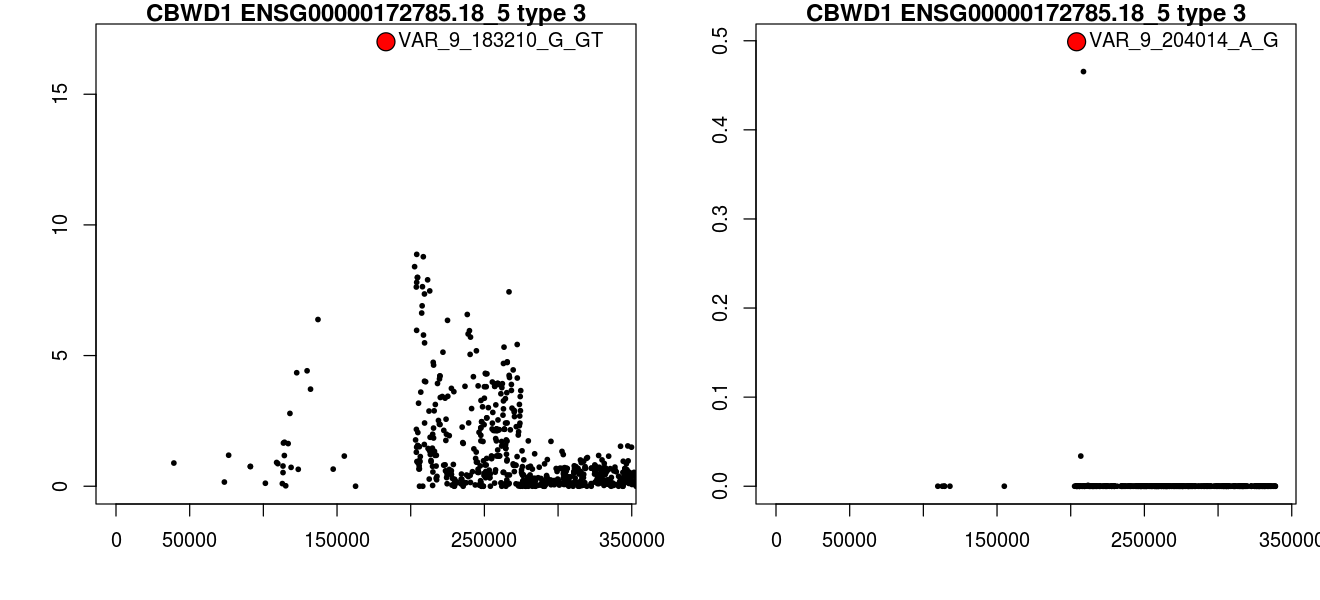

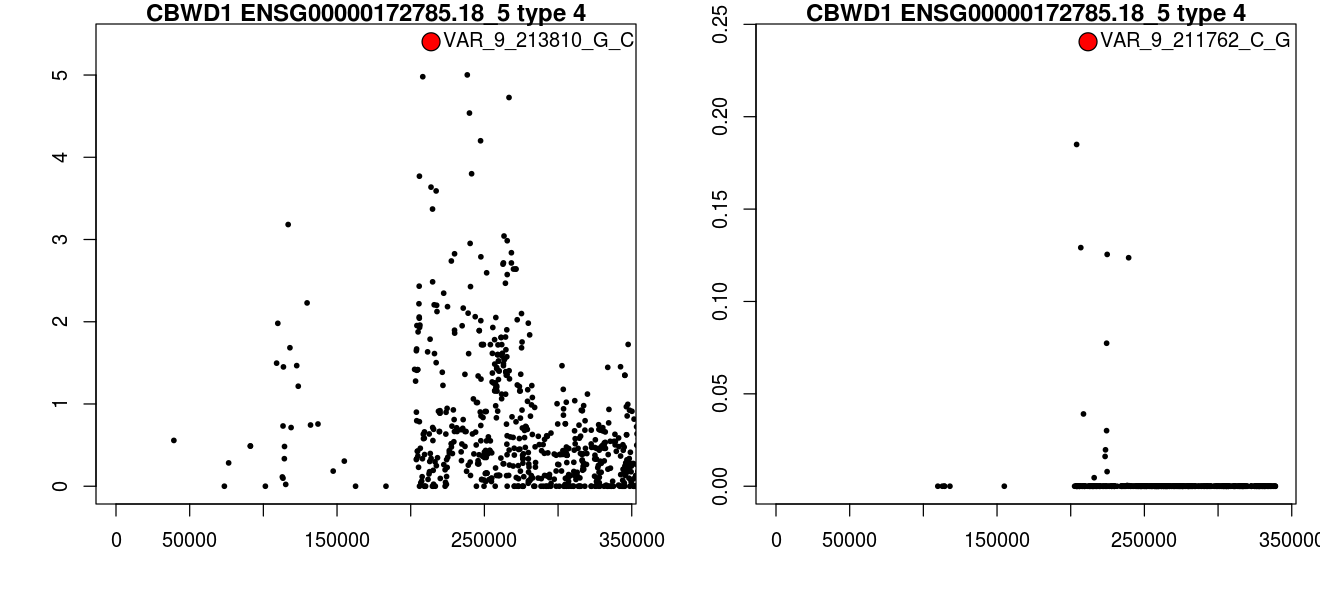

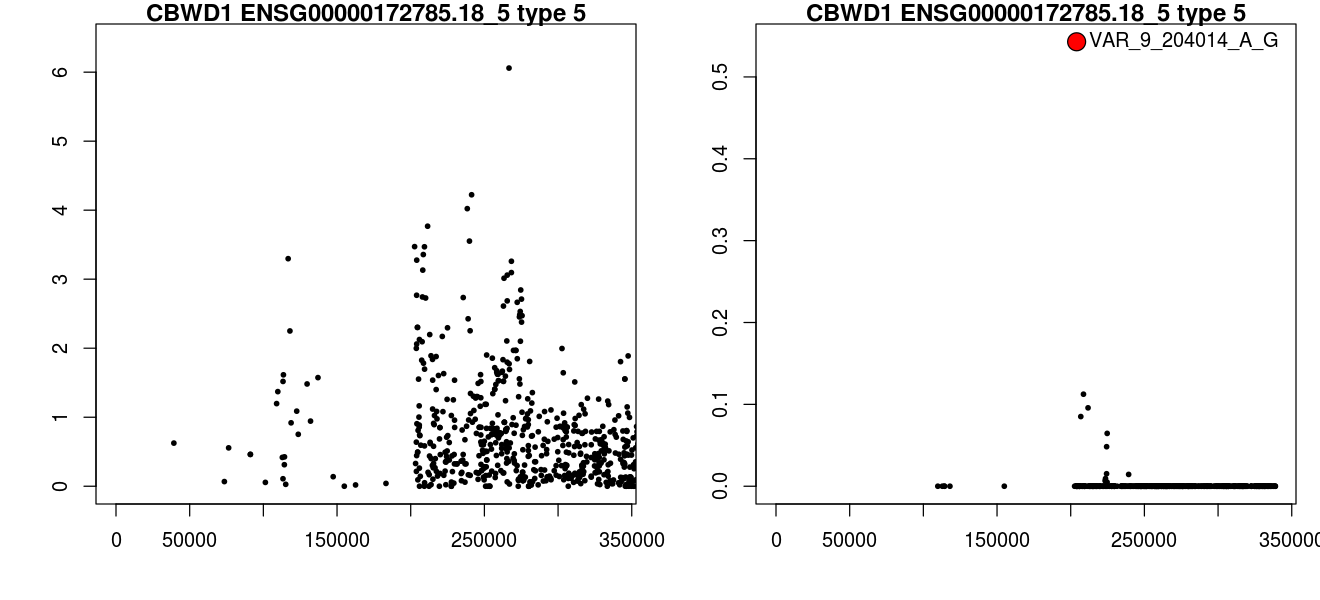

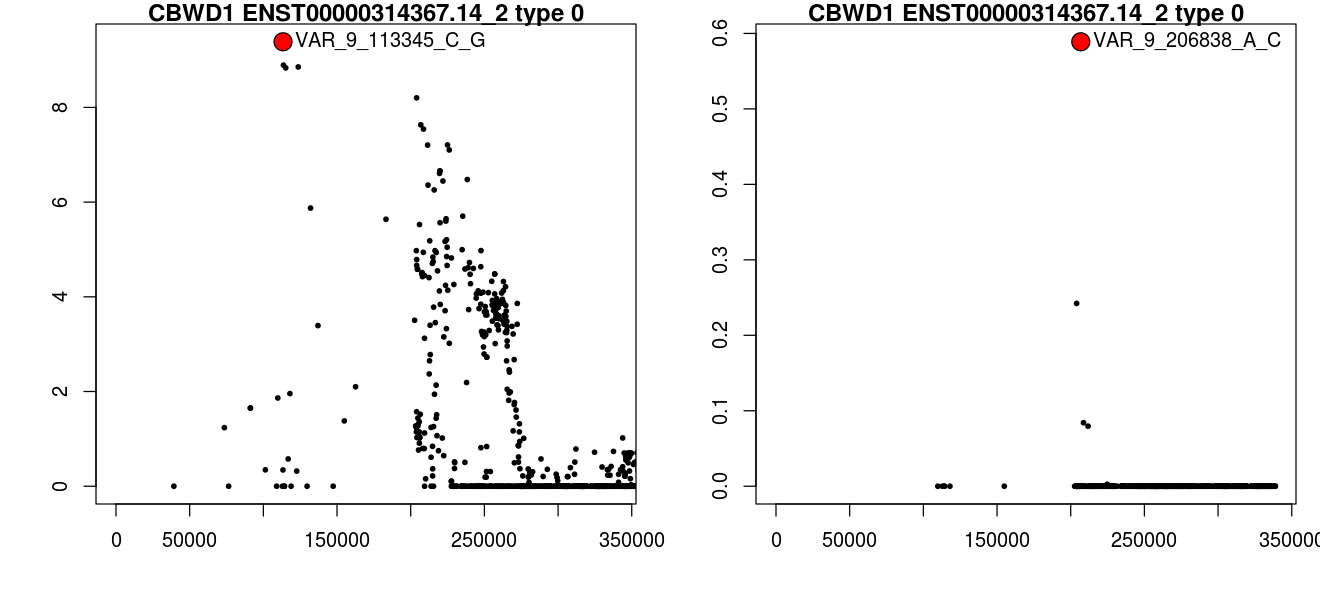

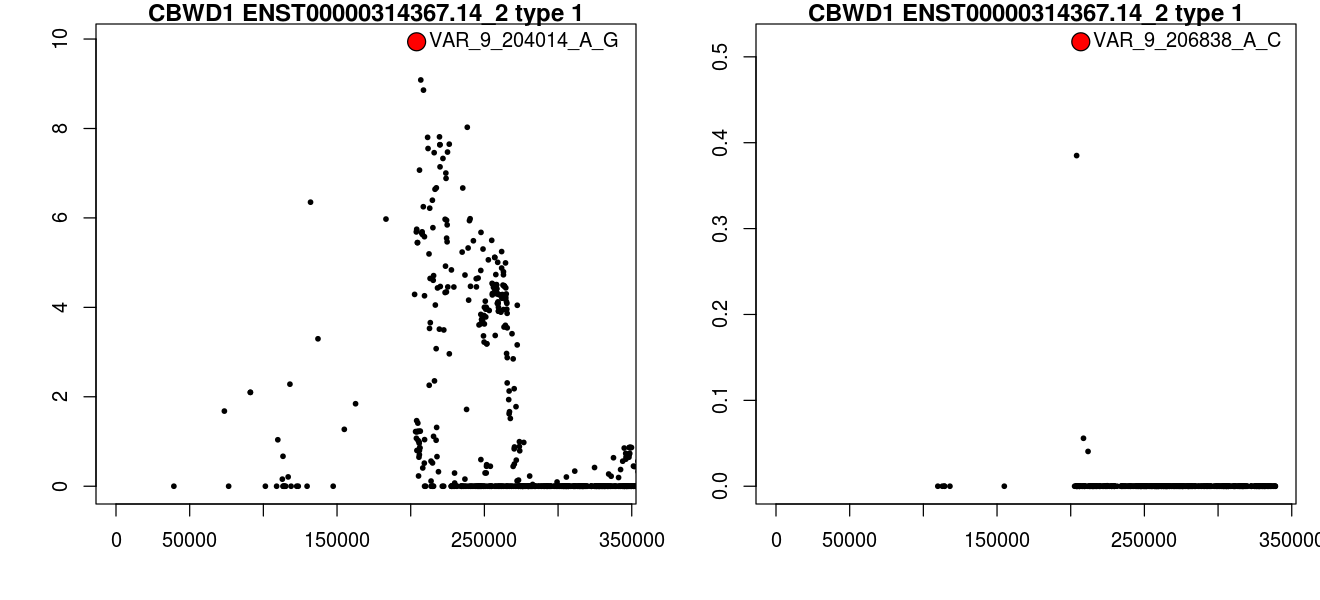

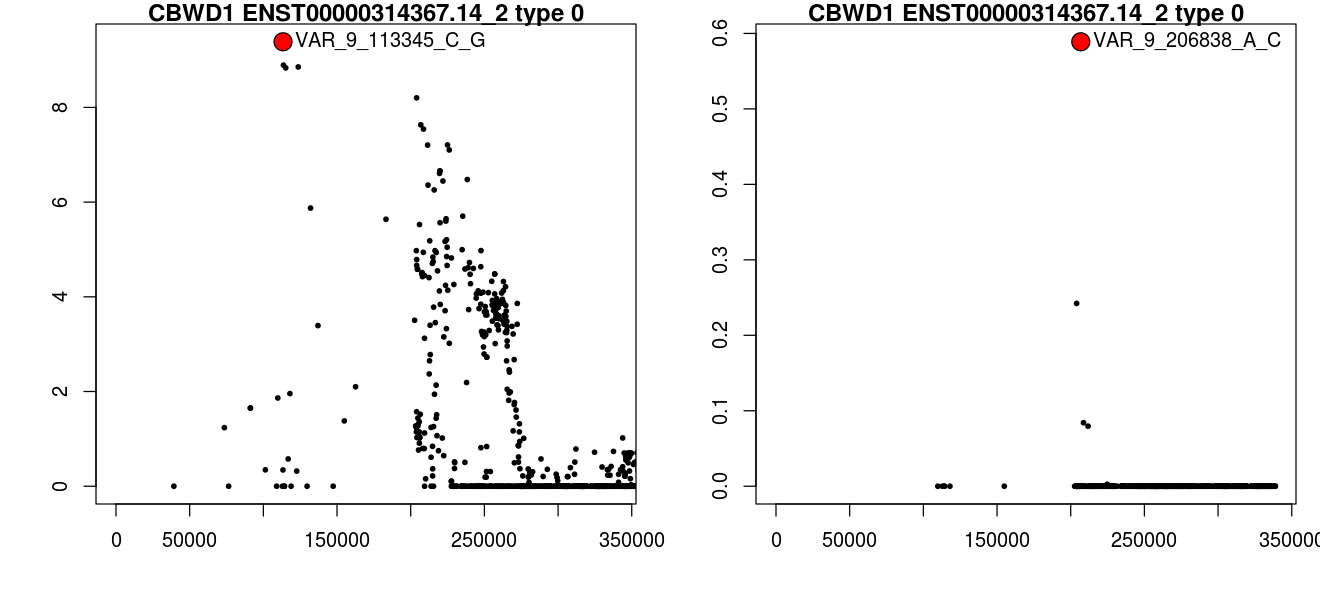

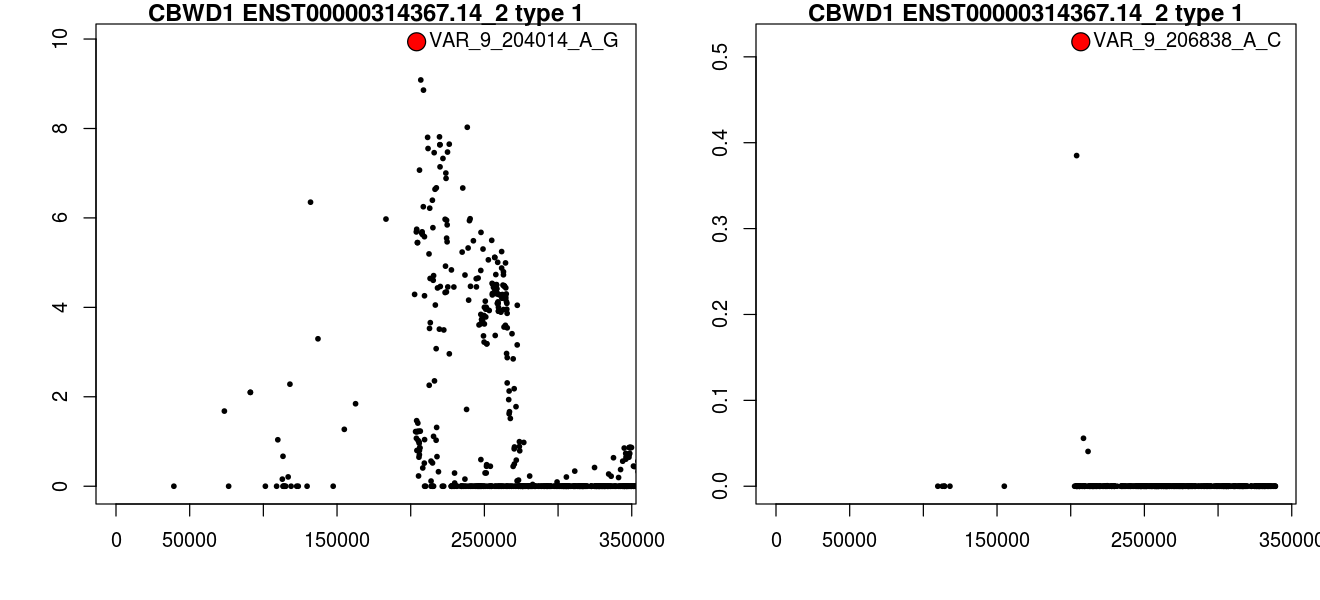

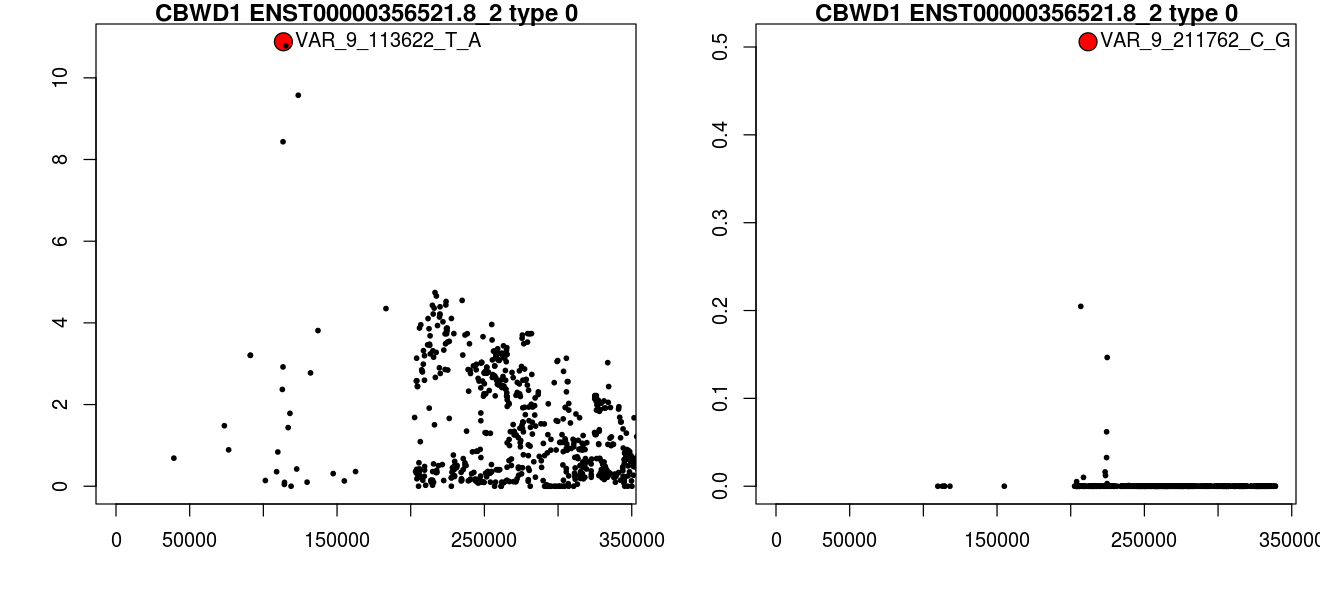

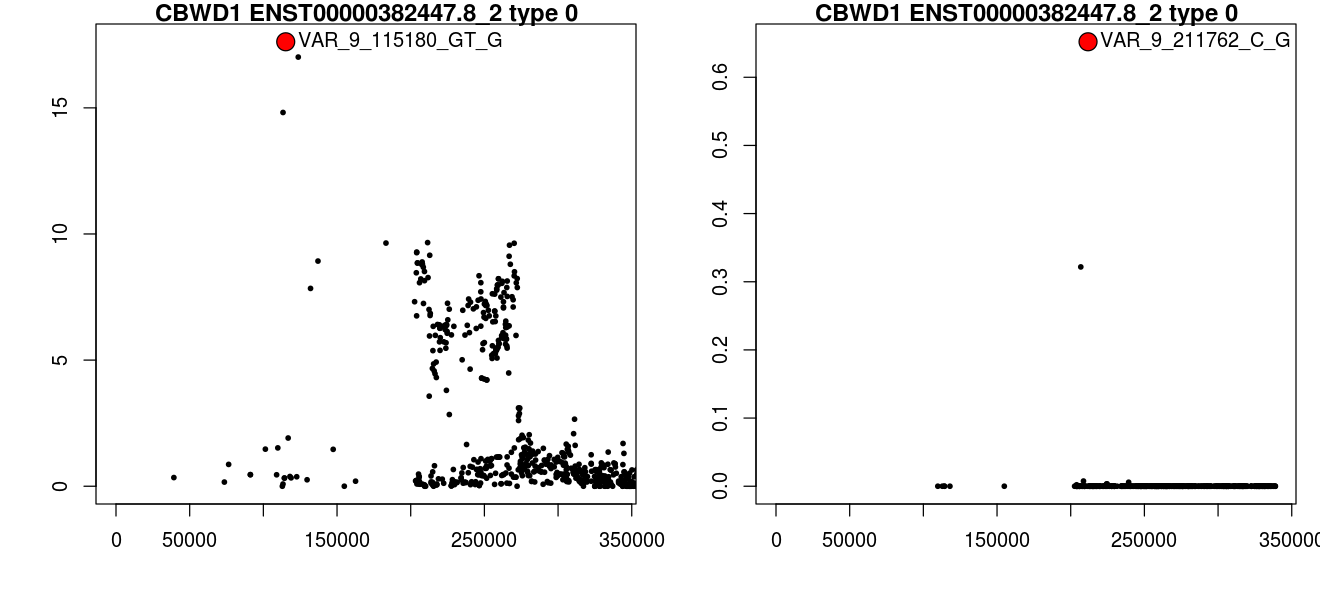

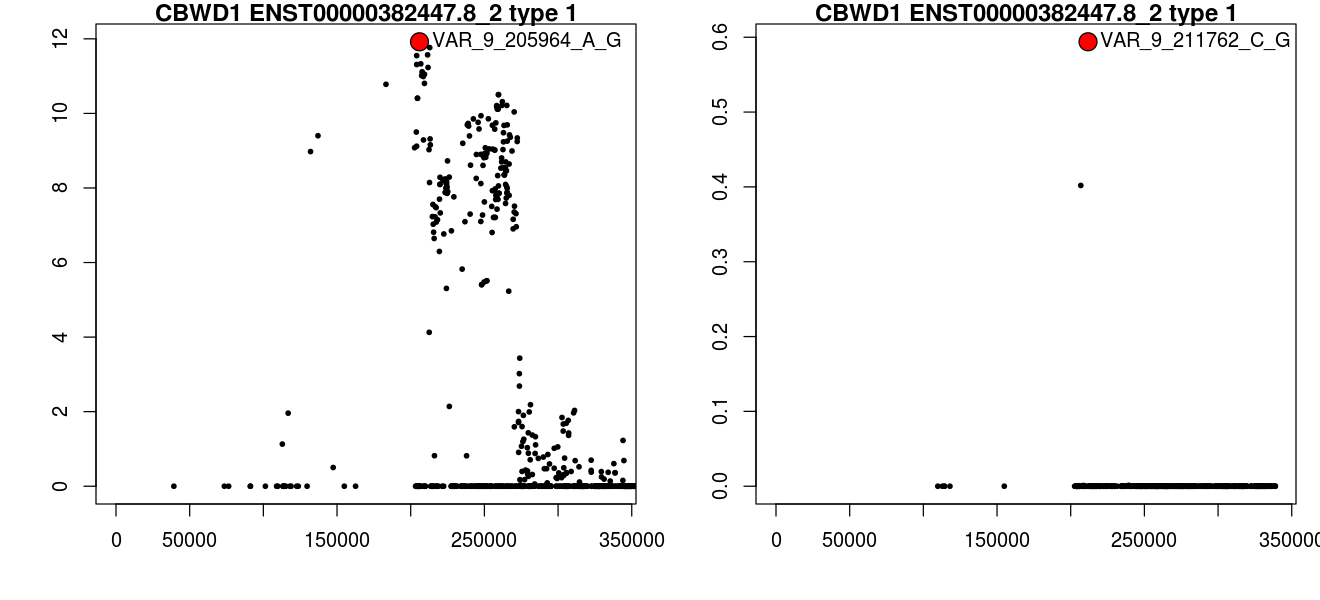

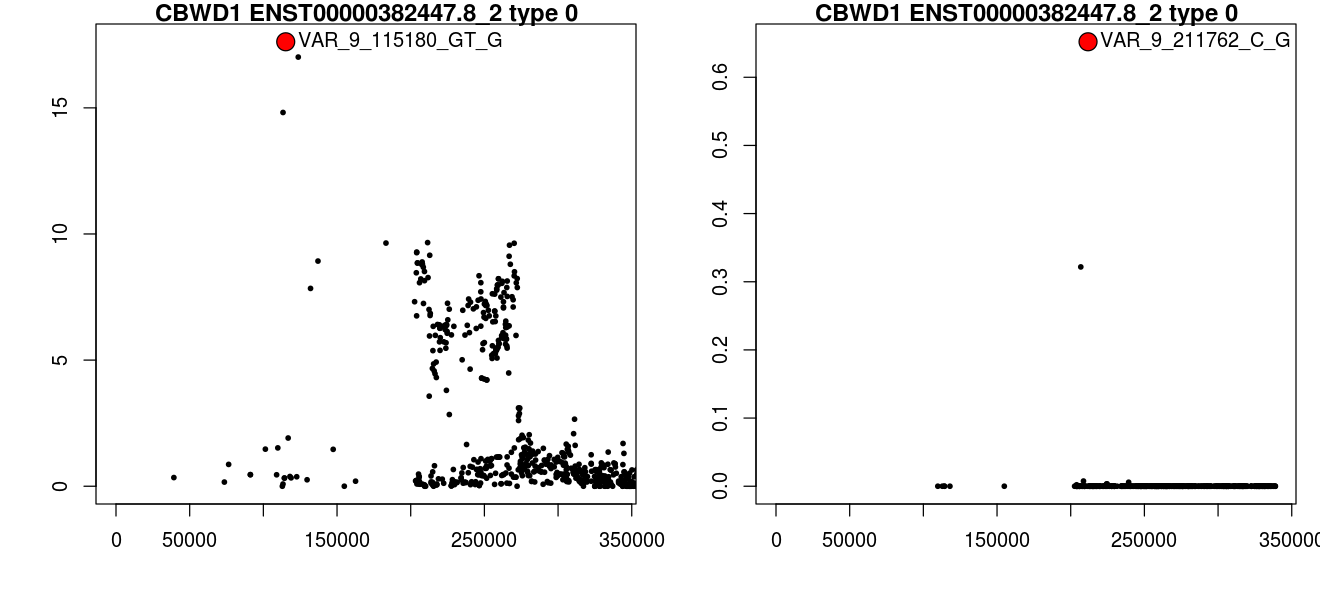

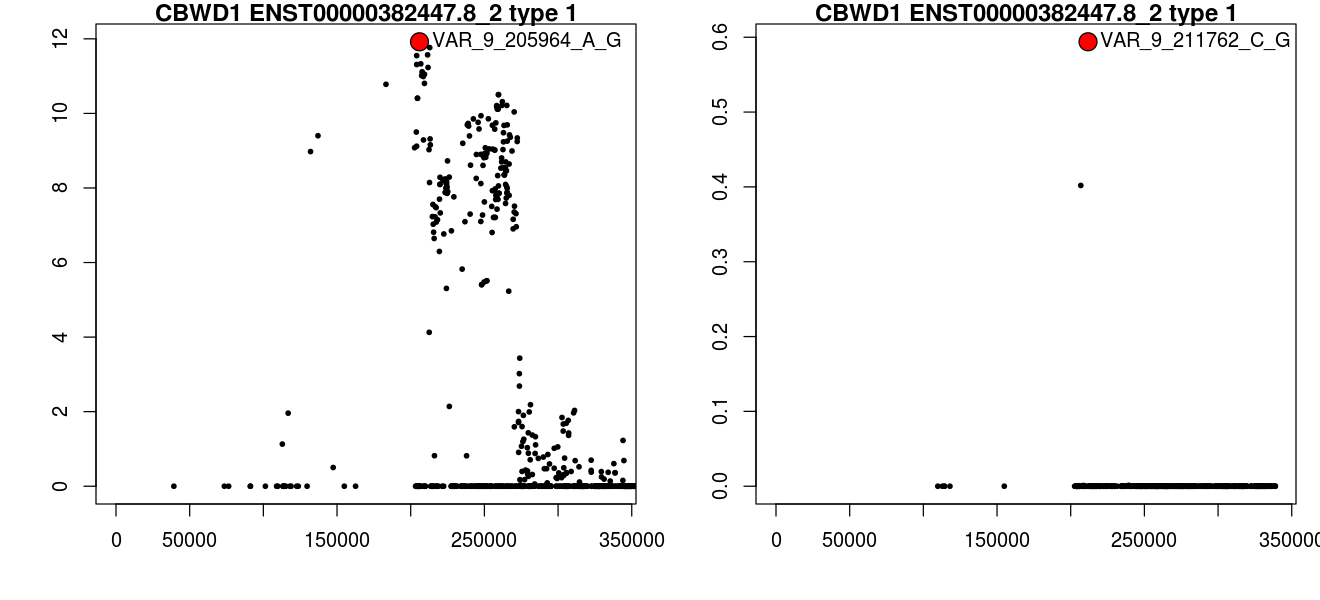

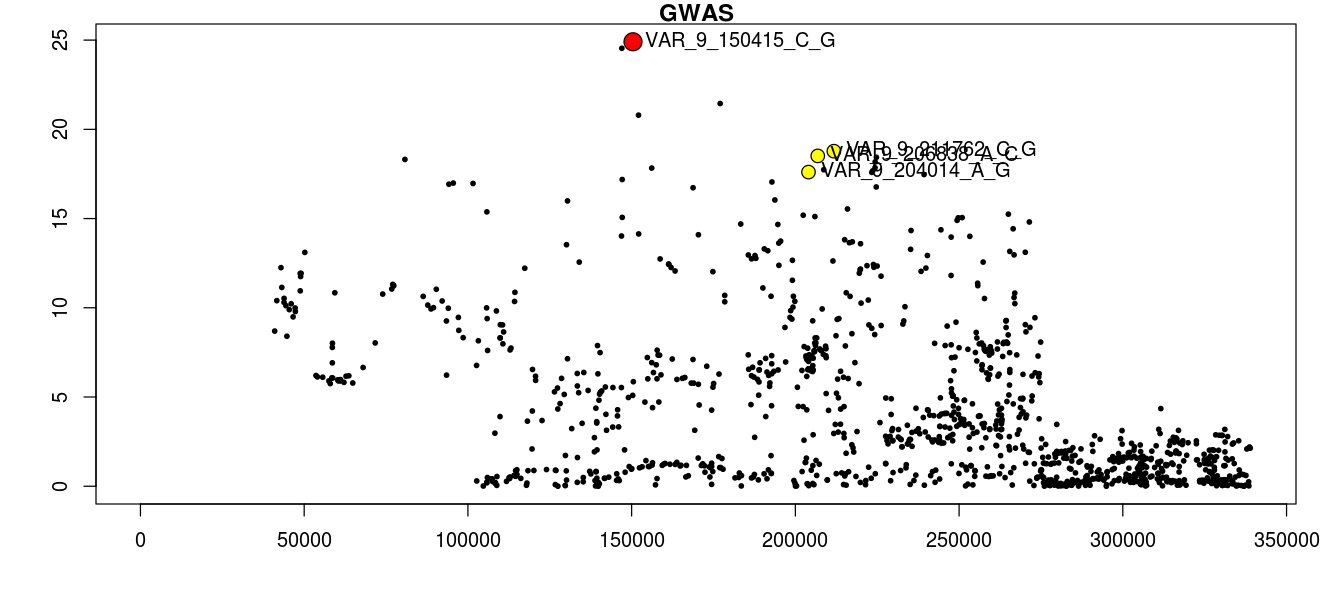

In [158]:
x = plot_example("9_0_339313.1", c("ENSG00000172785.18_5", "ENST00000314367.14_2", "ENST00000314367.14_2", "ENST00000356521.8_2", "ENST00000382447.8_2", "ENST00000382447.8_2"))


In [160]:
x[ order(x$pph4, decreasing = TRUE),]

transcript_id        id               pp_snp    pos    y         cex bg     
8  ENST00000314367.14_2 VAR_9_206838_A_C 0.5175436 206838 0.5175436 2   #ff0000
10 ENST00000314367.14_2 VAR_9_206838_A_C 0.5175436 206838 0.5175436 2   #ff0000
7  ENST00000314367.14_2 VAR_9_206838_A_C 0.5889197 206838 0.5889197 2   #ff0000
9  ENST00000314367.14_2 VAR_9_206838_A_C 0.5889197 206838 0.5889197 2   #ff0000
13 ENST00000382447.8_2  VAR_9_211762_C_G 0.5939247 211762 0.5939247 2   #ff0000
15 ENST00000382447.8_2  VAR_9_211762_C_G 0.5939247 211762 0.5939247 2   #ff0000
3  ENSG00000172785.18_5 VAR_9_204014_A_G 0.8627492 204014 0.8627492 2   #ff0000
11 ENST00000356521.8_2  VAR_9_211762_C_G 0.5059474 211762 0.5059474 2   #ff0000
1  ENSG00000172785.18_5 VAR_9_211762_C_G 0.5263040 211762 0.5263040 2   #ff0000
2  ENSG00000172785.18_5 VAR_9_204014_A_G 0.9374297 204014 0.9374297 2   #ff0000
12 ENST00000382447.8_2  VAR_9_211762_C_G 0.6520698 211762 0.6520698 2   #ff0000
14 ENST00000382447.8_2  VAR_9_211762_C_G 0.6520698 211762 0.6520698 2   #ff0000
6  ENSG00000172785.18_5 VAR_9_204014_A_G 0.5429411 204014 0.5429411 2   #ff0000
4  ENSG00000172785.18_5 VAR_9_204014_A_G 0.4988576 204014 0.4988576 2   #ff0000
5  ENSG00000172785.18_5 VAR_9_211762_C_G 0.2405613 211762 0.2405613 2   #ff0000
   pph4       type   gene_id              gene_name phenotype
8  0.98020086 type 1 ENSG00000172785.18_5 CBWD1     isoform  
10 0.98020086 type 1 ENSG00000172785.18_5 CBWD1     isoform  
7  0.98008012 type 0 ENSG00000172785.18_5 CBWD1     isoform  
9  0.98008012 type 0 ENSG00000172785.18_5 CBWD1     isoform  
13 0.97003507 type 1 ENSG00000172785.18_5 CBWD1     isoform  
15 0.97003507 type 1 ENSG00000172785.18_5 CBWD1     isoform  
3  0.93820689 type 2 ENSG00000172785.18_5 CBWD1     rna      
11 0.89871818 type 0 ENSG00000172785.18_5 CBWD1     isoform  
1  0.89668975 type 0 ENSG00000172785.18_5 CBWD1     rna      
2  0.86891051 type 1 ENSG00000172785.18_5 CBWD1     rna      
12 0.82737929 type 0 ENSG00000172785.18_5 CBWD1     isoform  
14 0.82737929 type 0 ENSG00000172785.18_5 CBWD1     isoform  
6  0.06685856 type 5 ENSG00000172785.18_5 CBWD1     rna      
4  0.04596819 type 3 ENSG00000172785.18_5 CBWD1     rna      
5  0.02083751 type 4 ENSG00000172785.18_5 CBWD1     rna

In [157]:
str(meta_list[["9_0_339313.1"]])

List of 9
 $ som                :'data.frame':	1 obs. of  5 variables:
  ..$ som    : num 391
  ..$ id     : chr "9_0_339313.1"
  ..$ locus  : chr "9_0_339313"
  ..$ cluster: int 27
  ..$ class  : chr "V391"
 $ traits_cluster     : chr [1:3] "continuous-MAP-both_sexes-combined_medadj_irnt" "continuous-PP-both_sexes-combined_medadj_irnt" "continuous-SBP-both_sexes-combined_medadj_irnt"
 $ eqtls              :'data.frame':	20 obs. of  8 variables:
  ..$ gene_id      : chr [1:20] "ENSG00000181404.17_7" "ENSG00000172785.18_5" "ENSG00000172785.18_5" "ENSG00000172785.18_5" ...
  ..$ gene_name    : chr [1:20] "WASHC1" "CBWD1" "CBWD1" "CBWD1" ...
  ..$ transcript_id: chr [1:20] "ENSG00000181404.17_7" "ENSG00000172785.18_5" "ENSG00000172785.18_5" "ENSG00000172785.18_5" ...
  ..$ type         : int [1:20] 1 1 2 3 0 4 0 5 0 0 ...
  ..$ chrom        : int [1:20] 9 9 9 9 9 9 9 9 9 9 ...
  ..$ start        : int [1:20] 14475 121038 121038 121038 121038 121038 214854 121038 14475 121060 ...
  ..$ end